In [1]:
from IPython.display import Image
from openseespy import opensees
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import gzip
from streng.ppp.sections.geometry.tee import TeeSectionGeometry
from streng.ppp.sections.geometry.rectangular import RectangularSectionGeometry
from streng.ppp.opensees.pre.elements.modified_ibarra_krawinkler import ModifiedIbarraKrawinkler
from streng.tools.seismic_motion import Record, Spectra
from streng.ppp.opensees.post.convert_local_axes import os_to_sap_forces_beam, os_to_sap_forces_col

Η αρίθμηση κόμβων, δομικών στοιχείων και πρόσθετων κόμβων για τα στοιχεία μηδενικού μήκους φαίνονται στο παρακάτω σχήμα

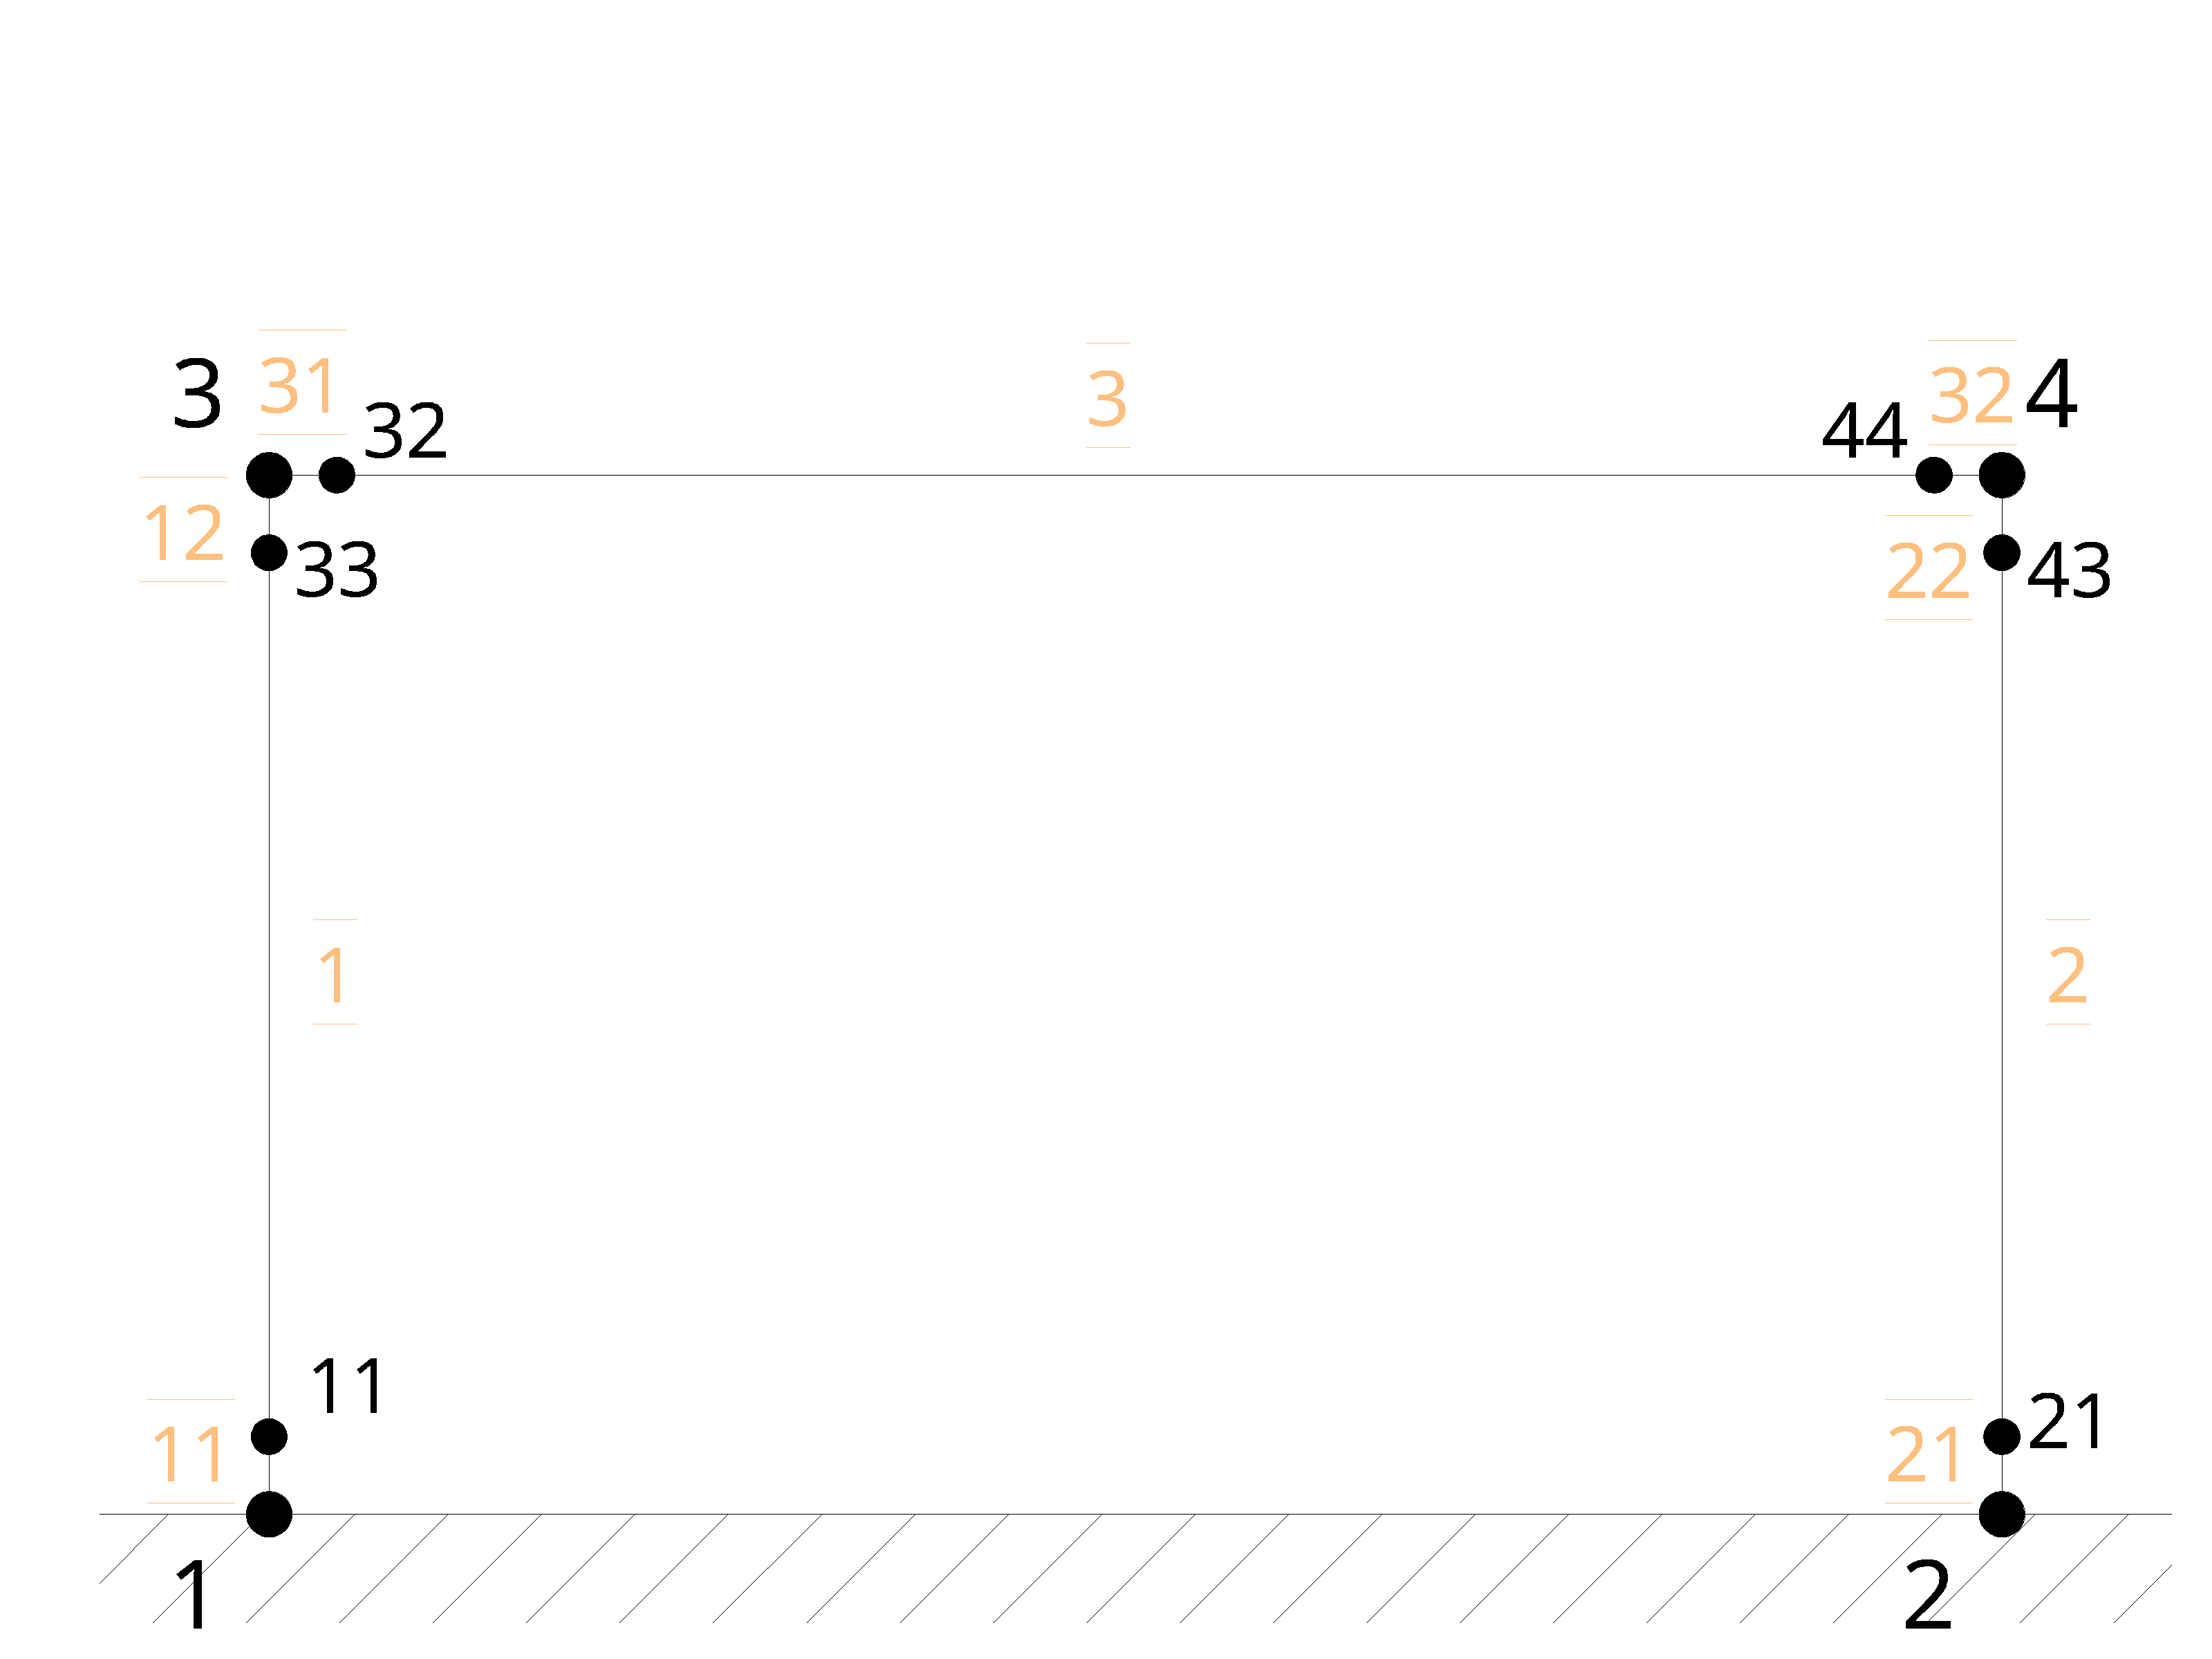

In [2]:
Image('opensees/nodes_elements.png', width=600)

In [3]:
elcrec_motion = Record.load_multi_column_txt('elCentro.dat', dt=0.02, skip_header=0, skip_footer=2)
elcrec_motion.calc()

input_motion = Record.load_multi_column_txt(filename='LEFL.dat', dt=0.01, skip_header=0, skip_footer=0)
input_motion.calc()

input_motion_points = len(input_motion.accel)
dt=0.01


In [4]:
E = 30000000.
U = 0.0
G = E / (2.0*(1.0+U))

# Βάζω μειωτικό συντελεστή 0.5 στη δυσκαμψία της δοκόύ
tbeam = TeeSectionGeometry(bw=0.25, h=0.70, beff=1.20, hf=0.15)
beam_A = tbeam.bw * tbeam.h 
beam_I = tbeam.moment_of_inertia_xx * 0.5
beam_sheararea = tbeam.shear_area_2

beam_My_pos=100.15
beam_Mu_pos=1.1*beam_My_pos
beam_θp_pos=0.025
beam_θpc_pos=0.030

beam_My_neg=146.36
beam_Mu_neg=1.1*beam_My_neg
beam_θp_neg=0.025
beam_θpc_neg=0.030


# Χωρίς μειωτικό συντελεστή για τη δυσκαμψία του στύλου
col = RectangularSectionGeometry(b=0.40, h=0.40)
col_A = col.area
col_I = col.moment_of_inertia_xx
col_sheararea = col.shear_area_2

col_My=236.97
col_Mu=1.1*col_My
col_θp=0.02
col_θpc=0.024

# Συντελεστ΄ής n για μοντέλο MIK
n_MIK = 10.
beam_I = beam_I * (n_MIK+1.0) / n_MIK
col_I = col_I * (n_MIK+1.0) / n_MIK

In [5]:
# General
opensees.wipe()
opensees.model('Basic', '-ndm', 2)
opensees.geomTransf('Linear', 1)

In [6]:
# Nodes
opensees.node(1, 0., 0.)
opensees.node(2, 5., 0.)
opensees.node(3, 0., 3.)
opensees.node(4, 5., 3.)

# extranodes
opensees.node(11, 0., 0.)
opensees.node(21, 5., 0.)
opensees.node(32, 0., 3.)
opensees.node(33, 0., 3.)
opensees.node(43, 5., 3.)
opensees.node(44, 5., 3.)

In [7]:
# Node fixes
opensees.fix(1, 1, 1, 1)
opensees.fix(2, 1, 1, 1)

In [8]:
# Nodal masses
opensees.mass(3, 11.723, 1.0e-10, 1.0e-10)

In [9]:
# Diaphragm - equalDOFs
opensees.equalDOF(3, 4, 1)

In [10]:
# ElasticTimoshenkoBeams
opensees.element('ElasticTimoshenkoBeam', 1, 11, 33, E, G, col_A, col_I, col_sheararea, 1) 
opensees.element('ElasticTimoshenkoBeam', 2, 21, 43, E, G, col_A, col_I, col_sheararea, 1) 
opensees.element('ElasticTimoshenkoBeam', 3, 32, 44, E, G, beam_A, beam_I, beam_sheararea, 1) 

In [11]:
beam_mIK = ModifiedIbarraKrawinkler(n=n_MIK, E=E, I=beam_I, L=5.0,
            My_P=beam_My_pos, McMy_P=1.1, th_pP=beam_θp_pos, th_pcP=beam_θpc_pos-beam_θp_pos,
            th_uP=4*beam_θp_pos,
            My_N=-beam_My_neg, McMy_N=1.1, th_pN=beam_θp_neg, th_pcN=beam_θpc_neg-beam_θp_neg,
            th_uN=4*beam_θp_neg)
beam_mIK.ResP = 0.2
beam_mIK.ResN = 0.2

col_mIK = ModifiedIbarraKrawinkler(n=n_MIK, E=E, I=col_I, L=3.0,
            My_P=col_My, McMy_P=1.1, th_pP=col_θp, th_pcP=col_θpc-col_θp,
            th_uP=4*col_θp,
            My_N=-col_My, McMy_N=1.1, th_pN=col_θp, th_pcN=col_θpc-col_θp,
            th_uN=4*col_θp)
col_mIK.ResP = 0.2
col_mIK.ResN = 0.2


mIK_model = 'peak' # 'peak' or 'bilin'

if mIK_model == 'peak':
    beam_mIK.opensees_peak_py(31, 3, 32)
    beam_mIK.opensees_peak_py(32, 44, 4, True)

    col_mIK.opensees_peak_py(11, 1, 11)
    col_mIK.opensees_peak_py(12, 33, 3, True)
    col_mIK.opensees_peak_py(21, 2, 21)
    col_mIK.opensees_peak_py(22, 43, 4, True)
else:
    beam_mIK.opensees_bilin_py(31, 3, 32)
    beam_mIK.opensees_bilin_py(32, 44, 4, True)

    col_mIK.opensees_bilin_py(11, 1, 11)
    col_mIK.opensees_bilin_py(12, 33, 3, True)
    col_mIK.opensees_bilin_py(21, 2, 21)
    col_mIK.opensees_bilin_py(22, 43, 4, True)

In [12]:
# eigen_analysis
numEigen = 1
eigenValue = opensees.eigen('-fullGenLapack', numEigen)

lamb = eigenValue
period = 2 * math.pi / math.sqrt(lamb)
print(f'Period = {period:.4f}s')

Period = 0.0987s


In [13]:
# Gravity loads
opensees.timeSeries('Linear', 1)
opensees.pattern('Plain', 101, 1)

opensees.eleLoad('-ele', 3, '-type', '-beamUniform', -23.0)

In [14]:
# Analysis for gravity loads
opensees.constraints('Plain')
opensees.numberer('RCM')
opensees.system('BandGeneral')
opensees.test('NormDispIncr', 1e-6, 6)
opensees.algorithm('Newton')
opensees.integrator('LoadControl', 0.1)
opensees.analysis('Static')
opensees.analyze(10)

opensees.loadConst('-time', 0.0)

opensees.record()

In [15]:
print('Τα εντατικά μεγέθη μετατρέπονται σύμφωνα με τα πρόσημα του sap σε N1 V1 M1 N2 V2 M2')
print('element 1: ' + str(os_to_sap_forces_col([round(val, 2) for val in opensees.eleResponse(1, 'force')])) + ' - Στύλος αριστερά')
print('element 2: ' + str(os_to_sap_forces_col([round(val, 2) for val in opensees.eleResponse(2, 'force')])) + ' - Στύλος δεξιά')
print('element 3: ' + str(os_to_sap_forces_beam([round(val, 2) for val in opensees.eleResponse(3, 'force')])) + ' - Δοκός')

print('')
print('Zero length elements')
print('element 11: ' + str(os_to_sap_forces_col([round(val, 2) for val in opensees.eleResponse(11, 'force')])) + ' - Στύλος αριστερά βάση')
print('element 12: ' + str(os_to_sap_forces_col([round(val, 2) for val in opensees.eleResponse(12, 'force')])) + ' - Στύλος αριστερά κορυφή')
print('element 21: ' + str(os_to_sap_forces_col([round(val, 2) for val in opensees.eleResponse(21, 'force')])) + ' - Στύλος δεξιά βάση')
print('element 22: ' + str(os_to_sap_forces_col([round(val, 2) for val in opensees.eleResponse(22, 'force')])) + ' - Στύλος δεξιά κορυφή')
print('')
print('element 31: ' + str(os_to_sap_forces_beam([round(val, 2) for val in opensees.eleResponse(31, 'force')])) + ' - Δοκός αριστερά')
print('element 32: ' + str(os_to_sap_forces_beam([round(val, 2) for val in opensees.eleResponse(32, 'force')])) + ' - Δοκός δεξιά')

Τα εντατικά μεγέθη μετατρέπονται σύμφωνα με τα πρόσημα του sap σε N1 V1 M1 N2 V2 M2
element 1: [-57.5, -10.7, -9.88, -57.5, -10.7, 22.22] - Στύλος αριστερά
element 2: [-57.5, 10.7, 9.88, -57.5, 10.7, -22.22] - Στύλος δεξιά
element 3: [0.0, -57.5, -22.22, 0.0, 57.5, -22.22] - Δοκός

Zero length elements
element 11: [-0.0, -0.0, -9.88, 0.0, 0.0, -9.88] - Στύλος αριστερά βάση
element 12: [-0.0, -0.0, 22.22, 0.0, 0.0, 22.22] - Στύλος αριστερά κορυφή
element 21: [-0.0, -0.0, 9.88, 0.0, 0.0, 9.88] - Στύλος δεξιά βάση
element 22: [-0.0, -0.0, -22.22, 0.0, 0.0, -22.22] - Στύλος δεξιά κορυφή

element 31: [0.0, -0.0, -22.22, 0.0, 0.0, -22.22] - Δοκός αριστερά
element 32: [0.0, -0.0, -22.22, 0.0, 0.0, -22.22] - Δοκός δεξιά


In [16]:
# Time history analysis
opensees.recorder('Node', '-file', 'opensees/droof.out', '-node', 3, '-dof', 1, 'disp')
opensees.recorder('Node', '-file', 'opensees/Vbase.out', '-node', 11, 21, '-dof', 1, 'reaction')

# # Ακόμα και αν δεν τυπώνω σε αρχείο, πρέπει να τρέχει το recorder για να βγάλει τις λίστες...γιατί όμως;;
# # Δεν είναι ανάγκη να υπάρχουν όλοι οι κόμβοι, φτάνει ένας, ακόμα και αν δεν είναι από αυτούς που ζητώ στη συνέχεια
# opensees.recorder('Node', '-file', 'base_level_nodes.out', '-node', self.model.base_level_nodes[0], '-dof', 1, 'reaction')

w1 = 2*math.pi / period # 2*math.pi / self.results.elastic_periods[0]
w2 = 2*math.pi / period # 2 * math.pi / self.results.elastic_periods[1]

zeta = 0.04
a0 = zeta*2.0*w1*w2/(w1+w2)
a1 = zeta * 2.0 / (w1+w2)
a1_mod = a1*(1.0+n_MIK)/n_MIK

print(f'a0={a0:.5f}')
print(f'a1={a1:.5f}')
print(f'a1_mod={a1_mod:.5f}')

opensees.rayleigh(a0, 0.0, 0.0, a1_mod)   


# Δημιουργώ λίστες για να αποθηκεύω τα αποτελέσματα
elements_for_out = [(1, 'col', ''), (2, 'col', ''), (3, 'beam', ''),
                    (11, 'col', 'zero'), (12, 'col', 'zero'),
                    (21, 'col', 'zero'), (22, 'col', 'zero'),
                    (31, 'beam', 'zero'), (32, 'beam', 'zero')]

out = dict()

roof_displacements = [0]
base_shears = [0]

for el in elements_for_out:
    if el[1] == 'col':
        out[f'element{el[0]}'] = [os_to_sap_forces_col(opensees.eleResponse(el[0], 'force'))]
        if el[2] == 'zero':
            out[f'element{el[0]}deformation'] = [opensees.eleResponse(el[0], 'deformation')]
    else:
        out[f'element{el[0]}'] = [os_to_sap_forces_beam(opensees.eleResponse(el[0], 'force'))]
        if el[2] == 'zero':
            out[f'element{el[0]}deformation'] = [opensees.eleResponse(el[0], 'deformation')] 


# Set time series to be passed to uniform excitation
opensees.timeSeries('Path', 2, '-filePath', 'LEFL.dat', '-dt', dt, '-factor', 79.81)

# Create UniformExcitation load pattern
#                         tag dir
opensees.pattern('UniformExcitation', 2, 1, '-accel', 2)

      

opensees.wipeAnalysis()
# opensees.pattern('Plain', 200, 2)
opensees.constraints('Plain')
opensees.numberer('RCM')
opensees.system('UmfPack')
opensees.test('RelativeEnergyIncr', 0.0001, 200, 2)
opensees.algorithm('NewtonLineSearch')
opensees.integrator('Newmark', 0.5, 0.25)
opensees.analysis('Transient')


tFinal = input_motion_points * dt
tCurrent = opensees.getTime()

ok = 0
time = [tCurrent]

# Perform the transient analysis
while ok == 0 and tCurrent < tFinal:

    ok = opensees.analyze(1, .001)

    # if the analysis fails try initial tangent iteration
    if ok != 0:
        print("regular newton failed .. lets try an initail stiffness for this step")
        opensees.test('NormDispIncr', 1.0e-3, 2000)
        opensees.algorithm('ModifiedNewton', '-initial')
        ok = opensees.analyze(1, .0001)
        if ok == 0:
            print("that worked .. back to regular newton")
        opensees.test('NormDispIncr', 1.0e-3, 2000)
        opensees.algorithm('NewtonLineSearch')

    tCurrent =opensees.getTime()

    time.append(tCurrent)

    currentDisp = opensees.nodeDisp(3, 1)
    roof_displacements.append(currentDisp)

    currentΒase_shear = 0.
    currentΒase_shear += opensees.nodeReaction(11, 1)
    currentΒase_shear += opensees.nodeReaction(21, 1)
    base_shears.append(currentΒase_shear)

    # more results
    # more results
    for el in elements_for_out:
        if el[1] == 'col':
            out[f'element{el[0]}'].append(os_to_sap_forces_col(opensees.eleResponse(el[0], 'force')))
            if el[2] == 'zero':
                out[f'element{el[0]}deformation'].append(opensees.eleResponse(el[0], 'deformation'))
        else:
            out[f'element{el[0]}'].append(os_to_sap_forces_beam(opensees.eleResponse(el[0], 'force')))
            if el[2] == 'zero':
                out[f'element{el[0]}deformation'].append(opensees.eleResponse(el[0], 'deformation'))

    print(tCurrent)

    
    
    
# ok = 0
# currentDisp = 0.0
# while ok == 0 and currentDisp < 0.1 * 3.0:
#     ok = opensees.analyze(1)
#     # if the analysis fails try initial tangent iteration
#     if ok != 0:
#         print(f'currentDisp = {currentDisp:.4f}m')
#         print("modified newton failed")
#         # break
#         print("regular newton failed .. lets try a KrylovNewton for this step")
#         opensees.test('NormDispIncr', 1.0e-5,  1000)
#         opensees.algorithm('KrylovNewton')
#         ok = opensees.analyze(1)
#         if ok == 0:
#             print("that worked .. back to regular newton")
#             opensees.test('NormDispIncr', 1e-5, 1000)
#             opensees.algorithm('Newton')

#     currentDisp = opensees.nodeDisp(3, 1)
#     roof_displacements.append(currentDisp)
    
#     currentΒase_shear = 0.
#     currentΒase_shear += opensees.nodeReaction(11, 1)
#     currentΒase_shear += opensees.nodeReaction(21, 1)
#     base_shears.append(currentΒase_shear)
    
# #     print(opensees.eleResponse(3, 'force'))
# #     print(opensees.nodeDisp(3, 1))
    
#     # more results
#     for el in elements_for_out:
#         out[f'element{el}'].append(opensees.eleResponse(el, 'force'))
        
#     for zel in zero_elements_for_out:
#         out[f'zeroelement{zel}'].append(opensees.eleResponse(zel, 'force')) 
#         out[f'zeroelement{zel}deformation'].append(opensees.eleResponse(zel, 'deformation')) 
    
    

out['roof_displacements'] = roof_displacements
out['base_shears'] = base_shears

a0=2.54644
a1=0.00063
a1_mod=0.00075
regular newton failed .. lets try an initail stiffness for this step
that worked .. back to regular newton
0.0001
0.0011
0.0021000000000000003
0.0031000000000000003
0.0041
0.0051
0.0061
0.0071
0.0081
0.0091
0.010100000000000001
0.011100000000000002
0.012100000000000003
0.013100000000000004
0.014100000000000005
0.015100000000000006
0.016100000000000007
0.017100000000000008
0.01810000000000001
0.01910000000000001
0.02010000000000001
0.02110000000000001
0.022100000000000012
0.023100000000000013
0.024100000000000014
0.025100000000000015
0.026100000000000016
0.027100000000000016
0.028100000000000017
0.029100000000000018
0.03010000000000002
0.03110000000000002
0.03210000000000002
0.03310000000000002
0.03410000000000002
0.03510000000000002
0.03610000000000002
0.03710000000000002
0.03810000000000002
0.039100000000000024
0.040100000000000025
0.041100000000000025
0.042100000000000026
0.04310000000000003
0.04410000000000003
0.04510000000000003
0.04610000000000

0.8831000000000008
0.8841000000000008
0.8851000000000008
0.8861000000000008
0.8871000000000008
0.8881000000000008
0.8891000000000008
0.8901000000000008
0.8911000000000008
0.8921000000000008
0.8931000000000008
0.8941000000000008
0.8951000000000008
0.8961000000000008
0.8971000000000008
0.8981000000000008
0.8991000000000008
0.9001000000000008
0.9011000000000008
0.9021000000000008
0.9031000000000008
0.9041000000000008
0.9051000000000008
0.9061000000000008
0.9071000000000008
0.9081000000000008
0.9091000000000008
0.9101000000000008
0.9111000000000008
0.9121000000000008
0.9131000000000008
0.9141000000000008
0.9151000000000008
0.9161000000000008
0.9171000000000008
0.9181000000000008
0.9191000000000008
0.9201000000000008
0.9211000000000008
0.9221000000000008
0.9231000000000008
0.9241000000000008
0.9251000000000008
0.9261000000000008
0.9271000000000008
0.9281000000000008
0.9291000000000008
0.9301000000000008
0.9311000000000008
0.9321000000000008
0.9331000000000008
0.9341000000000008
0.9351000000

1.3820999999999588
1.3830999999999587
1.3840999999999586
1.3850999999999585
1.3860999999999584
1.3870999999999583
1.3880999999999581
1.389099999999958
1.390099999999958
1.3910999999999578
1.3920999999999577
1.3930999999999576
1.3940999999999575
1.3950999999999574
1.3960999999999573
1.3970999999999572
1.398099999999957
1.399099999999957
1.4000999999999568
1.4010999999999567
1.4020999999999566
1.4030999999999565
1.4040999999999564
1.4050999999999563
1.4060999999999562
1.407099999999956
1.408099999999956
1.4090999999999558
1.4100999999999557
1.4110999999999556
1.4120999999999555
1.4130999999999554
1.4140999999999553
1.4150999999999552
1.416099999999955
1.417099999999955
1.4180999999999548
1.4190999999999547
1.4200999999999546
1.4210999999999545
1.4220999999999544
1.4230999999999543
1.4240999999999542
1.425099999999954
1.426099999999954
1.4270999999999538
1.4280999999999537
1.4290999999999536
1.4300999999999535
1.4310999999999534
1.4320999999999533
1.4330999999999532
1.434099999999953
1.43

1.8820999999999037
1.8830999999999036
1.8840999999999035
1.8850999999999034
1.8860999999999033
1.8870999999999032
1.888099999999903
1.889099999999903
1.8900999999999029
1.8910999999999027
1.8920999999999026
1.8930999999999025
1.8940999999999024
1.8950999999999023
1.8960999999999022
1.897099999999902
1.898099999999902
1.8990999999999019
1.9000999999999018
1.9010999999999016
1.9020999999999015
1.9030999999999014
1.9040999999999013
1.9050999999999012
1.906099999999901
1.907099999999901
1.9080999999999009
1.9090999999999008
1.9100999999999007
1.9110999999999005
1.9120999999999004
1.9130999999999003
1.9140999999999002
1.9150999999999
1.9160999999999
1.9170999999998999
1.9180999999998998
1.9190999999998997
1.9200999999998996
1.9210999999998994
1.9220999999998993
1.9230999999998992
1.9240999999998991
1.925099999999899
1.926099999999899
1.9270999999998988
1.9280999999998987
1.9290999999998986
1.9300999999998985
1.9310999999998983
1.9320999999998982
1.9330999999998981
1.934099999999898
1.935099

2.7220999999998114
2.7230999999998113
2.7240999999998112
2.725099999999811
2.726099999999811
2.727099999999811
2.728099999999811
2.7290999999998107
2.7300999999998106
2.7310999999998105
2.7320999999998103
2.7330999999998102
2.73409999999981
2.73509999999981
2.73609999999981
2.73709999999981
2.7380999999998097
2.7390999999998096
2.7400999999998095
2.7410999999998094
2.7420999999998092
2.743099999999809
2.744099999999809
2.745099999999809
2.746099999999809
2.7470999999998087
2.7480999999998086
2.7490999999998085
2.7500999999998084
2.7510999999998083
2.752099999999808
2.753099999999808
2.754099999999808
2.755099999999808
2.7560999999998077
2.7570999999998076
2.7580999999998075
2.7590999999998074
2.7600999999998073
2.761099999999807
2.762099999999807
2.763099999999807
2.764099999999807
2.7650999999998067
2.7660999999998066
2.7670999999998065
2.7680999999998064
2.7690999999998063
2.770099999999806
2.771099999999806
2.772099999999806
2.773099999999806
2.7740999999998057
2.7750999999998056
2.

3.380099999999739
3.381099999999739
3.3820999999997388
3.3830999999997386
3.3840999999997385
3.3850999999997384
3.3860999999997383
3.387099999999738
3.388099999999738
3.389099999999738
3.390099999999738
3.3910999999997378
3.3920999999997377
3.3930999999997375
3.3940999999997374
3.3950999999997373
3.396099999999737
3.397099999999737
3.398099999999737
3.399099999999737
3.4000999999997368
3.4010999999997367
3.4020999999997366
3.4030999999997364
3.4040999999997363
3.4050999999997362
3.406099999999736
3.407099999999736
3.408099999999736
3.409099999999736
3.4100999999997357
3.4110999999997356
3.4120999999997355
3.4130999999997353
3.4140999999997352
3.415099999999735
3.416099999999735
3.417099999999735
3.418099999999735
3.4190999999997347
3.4200999999997346
3.4210999999997345
3.4220999999997344
3.4230999999997342
3.424099999999734
3.425099999999734
3.426099999999734
3.427099999999734
3.4280999999997337
3.4290999999997336
3.4300999999997335
3.4310999999997334
3.4320999999997333
3.4330999999997

3.879099999999684
3.880099999999684
3.881099999999684
3.8820999999996837
3.8830999999996836
3.8840999999996835
3.8850999999996834
3.8860999999996833
3.887099999999683
3.888099999999683
3.889099999999683
3.890099999999683
3.8910999999996827
3.8920999999996826
3.8930999999996825
3.8940999999996824
3.8950999999996823
3.896099999999682
3.897099999999682
3.898099999999682
3.899099999999682
3.9000999999996817
3.9010999999996816
3.9020999999996815
3.9030999999996814
3.9040999999996813
3.905099999999681
3.906099999999681
3.907099999999681
3.908099999999681
3.9090999999996807
3.9100999999996806
3.9110999999996805
3.9120999999996804
3.9130999999996803
3.91409999999968
3.91509999999968
3.91609999999968
3.91709999999968
3.9180999999996797
3.9190999999996796
3.9200999999996795
3.9210999999996794
3.9220999999996793
3.923099999999679
3.924099999999679
3.925099999999679
3.926099999999679
3.9270999999996787
3.9280999999996786
3.9290999999996785
3.9300999999996784
3.9310999999996783
3.932099999999678
3.

4.379099999999798
4.380099999999798
4.381099999999798
4.382099999999799
4.383099999999799
4.384099999999799
4.3850999999998
4.3860999999998
4.3870999999998
4.388099999999801
4.389099999999801
4.390099999999801
4.391099999999802
4.392099999999802
4.393099999999802
4.394099999999803
4.395099999999803
4.396099999999803
4.397099999999804
4.398099999999804
4.399099999999804
4.400099999999805
4.401099999999805
4.402099999999805
4.403099999999806
4.404099999999806
4.405099999999806
4.406099999999807
4.407099999999807
4.408099999999807
4.409099999999808
4.410099999999808
4.411099999999808
4.412099999999809
4.413099999999809
4.414099999999809
4.41509999999981
4.41609999999981
4.41709999999981
4.418099999999811
4.419099999999811
4.420099999999811
4.421099999999812
4.422099999999812
4.423099999999812
4.424099999999813
4.425099999999813
4.426099999999813
4.427099999999814
4.428099999999814
4.429099999999814
4.430099999999815
4.431099999999815
4.432099999999815
4.433099999999816
4.434099999999816
4

5.258100000000091
5.259100000000092
5.260100000000092
5.261100000000092
5.262100000000093
5.263100000000093
5.264100000000093
5.265100000000094
5.266100000000094
5.267100000000094
5.268100000000095
5.269100000000095
5.270100000000095
5.271100000000096
5.272100000000096
5.273100000000096
5.274100000000097
5.275100000000097
5.276100000000097
5.277100000000098
5.278100000000098
5.279100000000098
5.280100000000099
5.281100000000099
5.282100000000099
5.2831000000001
5.2841000000001
5.2851000000001
5.286100000000101
5.287100000000101
5.288100000000101
5.289100000000102
5.290100000000102
5.291100000000102
5.292100000000103
5.293100000000103
5.294100000000103
5.295100000000104
5.296100000000104
5.297100000000104
5.298100000000105
5.299100000000105
5.300100000000105
5.301100000000106
5.302100000000106
5.303100000000106
5.304100000000107
5.305100000000107
5.306100000000107
5.307100000000108
5.308100000000108
5.309100000000108
5.310100000000109
5.311100000000109
5.312100000000109
5.31310000000011

5.79210000000027
5.79310000000027
5.79410000000027
5.795100000000271
5.796100000000271
5.797100000000271
5.798100000000272
5.799100000000272
5.800100000000272
5.801100000000273
5.802100000000273
5.803100000000273
5.804100000000274
5.805100000000274
5.806100000000274
5.807100000000275
5.808100000000275
5.809100000000275
5.810100000000276
5.811100000000276
5.812100000000276
5.813100000000277
5.814100000000277
5.815100000000277
5.816100000000278
5.817100000000278
5.818100000000278
5.819100000000279
5.820100000000279
5.821100000000279
5.82210000000028
5.82310000000028
5.82410000000028
5.825100000000281
5.826100000000281
5.827100000000281
5.828100000000282
5.829100000000282
5.830100000000282
5.831100000000283
5.832100000000283
5.833100000000283
5.834100000000284
5.835100000000284
5.836100000000284
5.837100000000285
5.838100000000285
5.839100000000285
5.840100000000286
5.841100000000286
5.842100000000286
5.843100000000287
5.844100000000287
5.845100000000287
5.846100000000288
5.84710000000028

6.376100000000465
6.377100000000465
6.378100000000465
6.379100000000466
6.380100000000466
6.381100000000466
6.382100000000467
6.383100000000467
6.384100000000467
6.385100000000468
6.386100000000468
6.387100000000468
6.388100000000469
6.389100000000469
6.390100000000469
6.39110000000047
6.39210000000047
6.39310000000047
6.394100000000471
6.395100000000471
6.396100000000471
6.397100000000472
6.398100000000472
6.399100000000472
6.400100000000473
6.401100000000473
6.402100000000473
6.403100000000474
6.404100000000474
6.405100000000474
6.406100000000475
6.407100000000475
6.408100000000475
6.409100000000476
6.410100000000476
6.411100000000476
6.412100000000477
6.413100000000477
6.414100000000477
6.415100000000478
6.416100000000478
6.417100000000478
6.418100000000479
6.419100000000479
6.420100000000479
6.42110000000048
6.42210000000048
6.42310000000048
6.424100000000481
6.425100000000481
6.426100000000481
6.427100000000482
6.428100000000482
6.429100000000482
6.430100000000483
6.43110000000048

6.876100000000632
6.877100000000632
6.878100000000632
6.879100000000633
6.880100000000633
6.881100000000633
6.882100000000634
6.883100000000634
6.884100000000634
6.885100000000635
6.886100000000635
6.887100000000635
6.888100000000636
6.889100000000636
6.890100000000636
6.891100000000637
6.892100000000637
6.893100000000637
6.894100000000638
6.895100000000638
6.896100000000638
6.897100000000639
6.898100000000639
6.899100000000639
6.90010000000064
6.90110000000064
6.90210000000064
6.903100000000641
6.904100000000641
6.905100000000641
6.906100000000642
6.907100000000642
6.908100000000642
6.909100000000643
6.910100000000643
6.911100000000643
6.912100000000644
6.913100000000644
6.914100000000644
6.915100000000645
6.916100000000645
6.917100000000645
6.918100000000646
6.919100000000646
6.920100000000646
6.921100000000647
6.922100000000647
6.923100000000647
6.924100000000648
6.925100000000648
6.926100000000648
6.927100000000649
6.928100000000649
6.929100000000649
6.93010000000065
6.931100000000

7.56010000000086
7.56110000000086
7.562100000000861
7.563100000000861
7.564100000000861
7.565100000000862
7.566100000000862
7.567100000000862
7.568100000000863
7.569100000000863
7.570100000000863
7.571100000000864
7.572100000000864
7.573100000000864
7.574100000000865
7.575100000000865
7.576100000000865
7.577100000000866
7.578100000000866
7.579100000000866
7.580100000000867
7.581100000000867
7.582100000000867
7.583100000000868
7.584100000000868
7.585100000000868
7.586100000000869
7.587100000000869
7.588100000000869
7.58910000000087
7.59010000000087
7.59110000000087
7.592100000000871
7.593100000000871
7.594100000000871
7.595100000000872
7.596100000000872
7.597100000000872
7.598100000000873
7.599100000000873
7.600100000000873
7.601100000000874
7.602100000000874
7.603100000000874
7.604100000000875
7.605100000000875
7.606100000000875
7.607100000000876
7.608100000000876
7.609100000000876
7.610100000000877
7.611100000000877
7.612100000000877
7.613100000000878
7.614100000000878
7.6151000000008

8.188100000000903
8.189100000000902
8.190100000000902
8.191100000000901
8.1921000000009
8.1931000000009
8.1941000000009
8.195100000000899
8.196100000000898
8.197100000000898
8.198100000000897
8.199100000000897
8.200100000000896
8.201100000000896
8.202100000000895
8.203100000000894
8.204100000000894
8.205100000000893
8.206100000000893
8.207100000000892
8.208100000000892
8.209100000000891
8.21010000000089
8.21110000000089
8.21210000000089
8.213100000000889
8.214100000000888
8.215100000000888
8.216100000000887
8.217100000000887
8.218100000000886
8.219100000000886
8.220100000000885
8.221100000000884
8.222100000000884
8.223100000000883
8.224100000000883
8.225100000000882
8.226100000000882
8.227100000000881
8.22810000000088
8.22910000000088
8.23010000000088
8.231100000000879
8.232100000000878
8.233100000000878
8.234100000000877
8.235100000000877
8.236100000000876
8.237100000000876
8.238100000000875
8.239100000000875
8.240100000000874
8.241100000000873
8.242100000000873
8.243100000000872
8.24

8.874100000000523
8.875100000000522
8.876100000000521
8.877100000000521
8.87810000000052
8.87910000000052
8.88010000000052
8.881100000000519
8.882100000000518
8.883100000000518
8.884100000000517
8.885100000000516
8.886100000000516
8.887100000000515
8.888100000000515
8.889100000000514
8.890100000000514
8.891100000000513
8.892100000000513
8.893100000000512
8.894100000000511
8.895100000000511
8.89610000000051
8.89710000000051
8.89810000000051
8.899100000000509
8.900100000000508
8.901100000000508
8.902100000000507
8.903100000000506
8.904100000000506
8.905100000000505
8.906100000000505
8.907100000000504
8.908100000000504
8.909100000000503
8.910100000000503
8.911100000000502
8.912100000000502
8.913100000000501
8.9141000000005
8.9151000000005
8.9161000000005
8.917100000000499
8.918100000000498
8.919100000000498
8.920100000000497
8.921100000000497
8.922100000000496
8.923100000000495
8.924100000000495
8.925100000000494
8.926100000000494
8.927100000000493
8.928100000000493
8.929100000000492
8.93

9.374100000000245
9.375100000000245
9.376100000000244
9.377100000000244
9.378100000000243
9.379100000000243
9.380100000000242
9.381100000000242
9.382100000000241
9.38310000000024
9.38410000000024
9.38510000000024
9.386100000000239
9.387100000000238
9.388100000000238
9.389100000000237
9.390100000000237
9.391100000000236
9.392100000000235
9.393100000000235
9.394100000000234
9.395100000000234
9.396100000000233
9.397100000000233
9.398100000000232
9.399100000000232
9.400100000000231
9.40110000000023
9.40210000000023
9.40310000000023
9.404100000000229
9.405100000000228
9.406100000000228
9.407100000000227
9.408100000000227
9.409100000000226
9.410100000000226
9.411100000000225
9.412100000000224
9.413100000000224
9.414100000000223
9.415100000000223
9.416100000000222
9.417100000000222
9.418100000000221
9.41910000000022
9.42010000000022
9.42110000000022
9.422100000000219
9.423100000000218
9.424100000000218
9.425100000000217
9.426100000000217
9.427100000000216
9.428100000000216
9.429100000000215
9

10.3580999999997
10.3590999999997
10.360099999999699
10.361099999999698
10.362099999999698
10.363099999999697
10.364099999999697
10.365099999999696
10.366099999999696
10.367099999999695
10.368099999999695
10.369099999999694
10.370099999999693
10.371099999999693
10.372099999999692
10.373099999999692
10.374099999999691
10.37509999999969
10.37609999999969
10.37709999999969
10.378099999999689
10.379099999999688
10.380099999999688
10.381099999999687
10.382099999999687
10.383099999999686
10.384099999999686
10.385099999999685
10.386099999999685
10.387099999999684
10.388099999999683
10.389099999999683
10.390099999999682
10.391099999999682
10.392099999999681
10.39309999999968
10.39409999999968
10.39509999999968
10.396099999999679
10.397099999999678
10.398099999999678
10.399099999999677
10.400099999999677
10.401099999999676
10.402099999999676
10.403099999999675
10.404099999999675
10.405099999999674
10.406099999999673
10.407099999999673
10.408099999999672
10.409099999999672
10.410099999999671
10.

10.847099999999429
10.848099999999429
10.849099999999428
10.850099999999427
10.851099999999427
10.852099999999426
10.853099999999426
10.854099999999425
10.855099999999425
10.856099999999424
10.857099999999424
10.858099999999423
10.859099999999422
10.860099999999422
10.861099999999421
10.86209999999942
10.86309999999942
10.86409999999942
10.865099999999419
10.866099999999419
10.867099999999418
10.868099999999417
10.869099999999417
10.870099999999416
10.871099999999416
10.872099999999415
10.873099999999415
10.874099999999414
10.875099999999414
10.876099999999413
10.877099999999412
10.878099999999412
10.879099999999411
10.88009999999941
10.88109999999941
10.88209999999941
10.88309999999941
10.884099999999409
10.885099999999408
10.886099999999407
10.887099999999407
10.888099999999406
10.889099999999406
10.890099999999405
10.891099999999405
10.892099999999404
10.893099999999404
10.894099999999403
10.895099999999402
10.896099999999402
10.897099999999401
10.8980999999994
10.8990999999994
10.9

11.372099999999138
11.373099999999138
11.374099999999137
11.375099999999136
11.376099999999136
11.377099999999135
11.378099999999135
11.379099999999134
11.380099999999134
11.381099999999133
11.382099999999133
11.383099999999132
11.384099999999131
11.385099999999131
11.38609999999913
11.38709999999913
11.38809999999913
11.389099999999129
11.390099999999128
11.391099999999128
11.392099999999127
11.393099999999126
11.394099999999126
11.395099999999125
11.396099999999125
11.397099999999124
11.398099999999124
11.399099999999123
11.400099999999123
11.401099999999122
11.402099999999121
11.403099999999121
11.40409999999912
11.40509999999912
11.40609999999912
11.407099999999119
11.408099999999118
11.409099999999118
11.410099999999117
11.411099999999117
11.412099999999116
11.413099999999115
11.414099999999115
11.415099999999114
11.416099999999114
11.417099999999113
11.418099999999113
11.419099999999112
11.420099999999112
11.421099999999111
11.42209999999911
11.42309999999911
11.42409999999911
11

11.872099999998861
11.87309999999886
11.87409999999886
11.87509999999886
11.876099999998859
11.877099999998858
11.878099999998858
11.879099999998857
11.880099999998857
11.881099999998856
11.882099999998855
11.883099999998855
11.884099999998854
11.885099999998854
11.886099999998853
11.887099999998853
11.888099999998852
11.889099999998852
11.890099999998851
11.89109999999885
11.89209999999885
11.89309999999885
11.894099999998849
11.895099999998848
11.896099999998848
11.897099999998847
11.898099999998847
11.899099999998846
11.900099999998845
11.901099999998845
11.902099999998844
11.903099999998844
11.904099999998843
11.905099999998843
11.906099999998842
11.907099999998842
11.908099999998841
11.90909999999884
11.91009999999884
11.91109999999884
11.912099999998839
11.913099999998838
11.914099999998838
11.915099999998837
11.916099999998837
11.917099999998836
11.918099999998836
11.919099999998835
11.920099999998834
11.921099999998834
11.922099999998833
11.923099999998833
11.924099999998832
11

12.871099999998307
12.872099999998307
12.873099999998306
12.874099999998306
12.875099999998305
12.876099999998305
12.877099999998304
12.878099999998303
12.879099999998303
12.880099999998302
12.881099999998302
12.882099999998301
12.8830999999983
12.8840999999983
12.8850999999983
12.886099999998299
12.887099999998298
12.888099999998298
12.889099999998297
12.890099999998297
12.891099999998296
12.892099999998296
12.893099999998295
12.894099999998295
12.895099999998294
12.896099999998293
12.897099999998293
12.898099999998292
12.899099999998292
12.900099999998291
12.90109999999829
12.90209999999829
12.90309999999829
12.904099999998289
12.905099999998288
12.906099999998288
12.907099999998287
12.908099999998287
12.909099999998286
12.910099999998286
12.911099999998285
12.912099999998285
12.913099999998284
12.914099999998284
12.915099999998283
12.916099999998282
12.917099999998282
12.918099999998281
12.91909999999828
12.92009999999828
12.92109999999828
12.922099999998279
12.923099999998279
12.92

13.339099999998048
13.340099999998047
13.341099999998047
13.342099999998046
13.343099999998046
13.344099999998045
13.345099999998045
13.346099999998044
13.347099999998044
13.348099999998043
13.349099999998042
13.350099999998042
13.351099999998041
13.35209999999804
13.35309999999804
13.35409999999804
13.355099999998039
13.356099999998039
13.357099999998038
13.358099999998037
13.359099999998037
13.360099999998036
13.361099999998036
13.362099999998035
13.363099999998035
13.364099999998034
13.365099999998034
13.366099999998033
13.367099999998032
13.368099999998032
13.369099999998031
13.37009999999803
13.37109999999803
13.37209999999803
13.37309999999803
13.374099999998029
13.375099999998028
13.376099999998027
13.377099999998027
13.378099999998026
13.379099999998026
13.380099999998025
13.381099999998025
13.382099999998024
13.383099999998024
13.384099999998023
13.385099999998022
13.386099999998022
13.387099999998021
13.38809999999802
13.38909999999802
13.39009999999802
13.39109999999802
13.3

14.295099999997518
14.296099999997518
14.297099999997517
14.298099999997516
14.299099999997516
14.300099999997515
14.301099999997515
14.302099999997514
14.303099999997514
14.304099999997513
14.305099999997513
14.306099999997512
14.307099999997511
14.308099999997511
14.30909999999751
14.31009999999751
14.31109999999751
14.312099999997509
14.313099999997508
14.314099999997508
14.315099999997507
14.316099999997506
14.317099999997506
14.318099999997505
14.319099999997505
14.320099999997504
14.321099999997504
14.322099999997503
14.323099999997503
14.324099999997502
14.325099999997501
14.326099999997501
14.3270999999975
14.3280999999975
14.3290999999975
14.330099999997499
14.331099999997498
14.332099999997498
14.333099999997497
14.334099999997497
14.335099999997496
14.336099999997495
14.337099999997495
14.338099999997494
14.339099999997494
14.340099999997493
14.341099999997493
14.342099999997492
14.343099999997492
14.344099999997491
14.34509999999749
14.34609999999749
14.34709999999749
14.34

15.369099999996923
15.370099999996922
15.371099999996922
15.372099999996921
15.37309999999692
15.37409999999692
15.37509999999692
15.376099999996919
15.377099999996918
15.378099999996918
15.379099999996917
15.380099999996917
15.381099999996916
15.382099999996916
15.383099999996915
15.384099999996915
15.385099999996914
15.386099999996913
15.387099999996913
15.388099999996912
15.389099999996912
15.390099999996911
15.39109999999691
15.39209999999691
15.39309999999691
15.394099999996909
15.395099999996908
15.396099999996908
15.397099999996907
15.398099999996907
15.399099999996906
15.400099999996906
15.401099999996905
15.402099999996905
15.403099999996904
15.404099999996903
15.405099999996903
15.406099999996902
15.407099999996902
15.408099999996901
15.4090999999969
15.4100999999969
15.4110999999969
15.412099999996899
15.413099999996899
15.414099999996898
15.415099999996897
15.416099999996897
15.417099999996896
15.418099999996896
15.419099999996895
15.420099999996895
15.421099999996894
15.42

15.869099999996646
15.870099999996645
15.871099999996645
15.872099999996644
15.873099999996644
15.874099999996643
15.875099999996642
15.876099999996642
15.877099999996641
15.87809999999664
15.87909999999664
15.88009999999664
15.88109999999664
15.882099999996639
15.883099999996638
15.884099999996637
15.885099999996637
15.886099999996636
15.887099999996636
15.888099999996635
15.889099999996635
15.890099999996634
15.891099999996634
15.892099999996633
15.893099999996632
15.894099999996632
15.895099999996631
15.89609999999663
15.89709999999663
15.89809999999663
15.89909999999663
15.900099999996629
15.901099999996628
15.902099999996627
15.903099999996627
15.904099999996626
15.905099999996626
15.906099999996625
15.907099999996625
15.908099999996624
15.909099999996624
15.910099999996623
15.911099999996623
15.912099999996622
15.913099999996621
15.91409999999662
15.91509999999662
15.91609999999662
15.91709999999662
15.918099999996619
15.919099999996618
15.920099999996618
15.921099999996617
15.92

16.811099999997566
16.812099999997567
16.81309999999757
16.81409999999757
16.81509999999757
16.816099999997572
16.817099999997573
16.818099999997575
16.819099999997576
16.820099999997577
16.82109999999758
16.82209999999758
16.82309999999758
16.824099999997582
16.825099999997583
16.826099999997584
16.827099999997586
16.828099999997587
16.829099999997588
16.83009999999759
16.83109999999759
16.83209999999759
16.833099999997593
16.834099999997594
16.835099999997595
16.836099999997597
16.837099999997598
16.8380999999976
16.8390999999976
16.8400999999976
16.841099999997603
16.842099999997604
16.843099999997605
16.844099999997606
16.845099999997608
16.84609999999761
16.84709999999761
16.84809999999761
16.849099999997613
16.850099999997614
16.851099999997615
16.852099999997616
16.853099999997617
16.85409999999762
16.85509999999762
16.85609999999762
16.857099999997622
16.858099999997624
16.859099999997625
16.860099999997626
16.861099999997627
16.86209999999763
16.86309999999763
16.8640999999976

17.368099999998247
17.369099999998248
17.37009999999825
17.37109999999825
17.37209999999825
17.373099999998253
17.374099999998254
17.375099999998255
17.376099999998257
17.377099999998258
17.37809999999826
17.37909999999826
17.38009999999826
17.381099999998263
17.382099999998264
17.383099999998265
17.384099999998266
17.385099999998268
17.38609999999827
17.38709999999827
17.38809999999827
17.389099999998272
17.390099999998274
17.391099999998275
17.392099999998276
17.393099999998277
17.39409999999828
17.39509999999828
17.39609999999828
17.397099999998282
17.398099999998283
17.399099999998285
17.400099999998286
17.401099999998287
17.40209999999829
17.40309999999829
17.40409999999829
17.405099999998292
17.406099999998293
17.407099999998294
17.408099999998296
17.409099999998297
17.410099999998298
17.4110999999983
17.4120999999983
17.413099999998302
17.414099999998303
17.415099999998304
17.416099999998305
17.417099999998307
17.418099999998308
17.41909999999831
17.42009999999831
17.42109999999

17.867099999998857
17.868099999998858
17.86909999999886
17.87009999999886
17.87109999999886
17.872099999998863
17.873099999998864
17.874099999998865
17.875099999998866
17.876099999998868
17.87709999999887
17.87809999999887
17.87909999999887
17.880099999998873
17.881099999998874
17.882099999998875
17.883099999998876
17.884099999998877
17.88509999999888
17.88609999999888
17.88709999999888
17.888099999998882
17.889099999998884
17.890099999998885
17.891099999998886
17.892099999998887
17.89309999999889
17.89409999999889
17.89509999999889
17.896099999998892
17.897099999998893
17.898099999998895
17.899099999998896
17.900099999998897
17.9010999999989
17.9020999999989
17.9030999999989
17.904099999998902
17.905099999998903
17.906099999998904
17.907099999998906
17.908099999998907
17.909099999998908
17.91009999999891
17.91109999999891
17.91209999999891
17.913099999998913
17.914099999998914
17.915099999998915
17.916099999998917
17.917099999998918
17.91809999999892
17.91909999999892
17.9200999999989

18.86710000000008
18.86810000000008
18.86910000000008
18.870100000000082
18.871100000000084
18.872100000000085
18.873100000000086
18.874100000000087
18.87510000000009
18.87610000000009
18.87710000000009
18.878100000000092
18.879100000000093
18.880100000000095
18.881100000000096
18.882100000000097
18.8831000000001
18.8841000000001
18.8851000000001
18.886100000000102
18.887100000000103
18.888100000000104
18.889100000000106
18.890100000000107
18.891100000000108
18.89210000000011
18.89310000000011
18.894100000000112
18.895100000000113
18.896100000000114
18.897100000000115
18.898100000000117
18.899100000000118
18.90010000000012
18.90110000000012
18.90210000000012
18.903100000000123
18.904100000000124
18.905100000000125
18.906100000000126
18.907100000000128
18.90810000000013
18.90910000000013
18.91010000000013
18.911100000000133
18.912100000000134
18.913100000000135
18.914100000000136
18.915100000000137
18.91610000000014
18.91710000000014
18.91810000000014
18.919100000000142
18.9201000000001

19.36610000000069
19.36710000000069
19.36810000000069
19.369100000000692
19.370100000000694
19.371100000000695
19.372100000000696
19.373100000000697
19.3741000000007
19.3751000000007
19.3761000000007
19.377100000000702
19.378100000000703
19.379100000000705
19.380100000000706
19.381100000000707
19.382100000000708
19.38310000000071
19.38410000000071
19.385100000000712
19.386100000000713
19.387100000000714
19.388100000000716
19.389100000000717
19.390100000000718
19.39110000000072
19.39210000000072
19.39310000000072
19.394100000000723
19.395100000000724
19.396100000000725
19.397100000000727
19.398100000000728
19.39910000000073
19.40010000000073
19.40110000000073
19.402100000000733
19.403100000000734
19.404100000000735
19.405100000000736
19.406100000000738
19.40710000000074
19.40810000000074
19.40910000000074
19.410100000000742
19.411100000000744
19.412100000000745
19.413100000000746
19.414100000000747
19.41510000000075
19.41610000000075
19.41710000000075
19.418100000000752
19.4191000000007

20.30010000000183
20.30110000000183
20.302100000001833
20.303100000001834
20.304100000001835
20.305100000001836
20.306100000001837
20.30710000000184
20.30810000000184
20.30910000000184
20.310100000001842
20.311100000001844
20.312100000001845
20.313100000001846
20.314100000001847
20.31510000000185
20.31610000000185
20.31710000000185
20.318100000001852
20.319100000001853
20.320100000001855
20.321100000001856
20.322100000001857
20.32310000000186
20.32410000000186
20.32510000000186
20.326100000001862
20.327100000001863
20.328100000001864
20.329100000001866
20.330100000001867
20.331100000001868
20.33210000000187
20.33310000000187
20.33410000000187
20.335100000001873
20.336100000001874
20.337100000001875
20.338100000001877
20.339100000001878
20.34010000000188
20.34110000000188
20.34210000000188
20.343100000001883
20.344100000001884
20.345100000001885
20.346100000001886
20.347100000001888
20.34810000000189
20.34910000000189
20.35010000000189
20.351100000001892
20.352100000001894
20.3531000000

21.36510000000313
21.366100000003133
21.367100000003134
21.368100000003135
21.369100000003137
21.370100000003138
21.37110000000314
21.37210000000314
21.37310000000314
21.374100000003143
21.375100000003144
21.376100000003145
21.377100000003146
21.378100000003148
21.37910000000315
21.38010000000315
21.38110000000315
21.382100000003152
21.383100000003154
21.384100000003155
21.385100000003156
21.386100000003157
21.38710000000316
21.38810000000316
21.38910000000316
21.390100000003162
21.391100000003163
21.392100000003165
21.393100000003166
21.394100000003167
21.39510000000317
21.39610000000317
21.39710000000317
21.398100000003172
21.399100000003173
21.400100000003174
21.401100000003176
21.402100000003177
21.403100000003178
21.40410000000318
21.40510000000318
21.406100000003182
21.407100000003183
21.408100000003184
21.409100000003185
21.410100000003187
21.411100000003188
21.41210000000319
21.41310000000319
21.41410000000319
21.415100000003193
21.416100000003194
21.417100000003195
21.41810000

21.86410000000374
21.865100000003743
21.866100000003744
21.867100000003745
21.868100000003746
21.869100000003748
21.87010000000375
21.87110000000375
21.87210000000375
21.873100000003753
21.874100000003754
21.875100000003755
21.876100000003756
21.877100000003757
21.87810000000376
21.87910000000376
21.88010000000376
21.881100000003762
21.882100000003764
21.883100000003765
21.884100000003766
21.885100000003767
21.88610000000377
21.88710000000377
21.88810000000377
21.889100000003772
21.890100000003773
21.891100000003775
21.892100000003776
21.893100000003777
21.894100000003778
21.89510000000378
21.89610000000378
21.897100000003782
21.898100000003783
21.899100000003784
21.900100000003786
21.901100000003787
21.902100000003788
21.90310000000379
21.90410000000379
21.90510000000379
21.906100000003793
21.907100000003794
21.908100000003795
21.909100000003797
21.910100000003798
21.9111000000038
21.9121000000038
21.9131000000038
21.914100000003803
21.915100000003804
21.916100000003805
21.91710000000

22.864100000004964
22.865100000004965
22.866100000004966
22.867100000004967
22.86810000000497
22.86910000000497
22.87010000000497
22.871100000004972
22.872100000004973
22.873100000004975
22.874100000004976
22.875100000004977
22.87610000000498
22.87710000000498
22.87810000000498
22.879100000004982
22.880100000004983
22.881100000004984
22.882100000004986
22.883100000004987
22.884100000004988
22.88510000000499
22.88610000000499
22.887100000004992
22.888100000004993
22.889100000004994
22.890100000004995
22.891100000004997
22.892100000004998
22.893100000005
22.894100000005
22.895100000005
22.896100000005003
22.897100000005004
22.898100000005005
22.899100000005006
22.900100000005008
22.90110000000501
22.90210000000501
22.90310000000501
22.904100000005013
22.905100000005014
22.906100000005015
22.907100000005016
22.908100000005017
22.90910000000502
22.91010000000502
22.91110000000502
22.912100000005022
22.913100000005024
22.914100000005025
22.915100000005026
22.916100000005027
22.9171000000050

23.363100000005574
23.364100000005575
23.365100000005576
23.366100000005577
23.36710000000558
23.36810000000558
23.36910000000558
23.370100000005582
23.371100000005583
23.372100000005585
23.373100000005586
23.374100000005587
23.375100000005588
23.37610000000559
23.37710000000559
23.378100000005592
23.379100000005593
23.380100000005594
23.381100000005596
23.382100000005597
23.383100000005598
23.3841000000056
23.3851000000056
23.3861000000056
23.387100000005603
23.388100000005604
23.389100000005605
23.390100000005607
23.391100000005608
23.39210000000561
23.39310000000561
23.39410000000561
23.395100000005613
23.396100000005614
23.397100000005615
23.398100000005616
23.399100000005618
23.40010000000562
23.40110000000562
23.40210000000562
23.403100000005622
23.404100000005624
23.405100000005625
23.406100000005626
23.407100000005627
23.40810000000563
23.40910000000563
23.41010000000563
23.411100000005632
23.412100000005633
23.413100000005635
23.414100000005636
23.415100000005637
23.4161000000

24.363100000006796
24.364100000006797
24.365100000006798
24.3661000000068
24.3671000000068
24.3681000000068
24.369100000006803
24.370100000006804
24.371100000006805
24.372100000006807
24.373100000006808
24.37410000000681
24.37510000000681
24.37610000000681
24.377100000006813
24.378100000006814
24.379100000006815
24.380100000006816
24.381100000006818
24.38210000000682
24.38310000000682
24.38410000000682
24.385100000006823
24.386100000006824
24.387100000006825
24.388100000006826
24.389100000006827
24.39010000000683
24.39110000000683
24.39210000000683
24.393100000006832
24.394100000006834
24.395100000006835
24.396100000006836
24.397100000006837
24.39810000000684
24.39910000000684
24.40010000000684
24.401100000006842
24.402100000006843
24.403100000006845
24.404100000006846
24.405100000006847
24.406100000006848
24.40710000000685
24.40810000000685
24.409100000006852
24.410100000006853
24.411100000006854
24.412100000006856
24.413100000006857
24.414100000006858
24.41510000000686
24.41610000000

24.862100000007405
24.863100000007407
24.864100000007408
24.86510000000741
24.86610000000741
24.86710000000741
24.868100000007413
24.869100000007414
24.870100000007415
24.871100000007416
24.872100000007418
24.87310000000742
24.87410000000742
24.87510000000742
24.876100000007423
24.877100000007424
24.878100000007425
24.879100000007426
24.880100000007427
24.88110000000743
24.88210000000743
24.88310000000743
24.884100000007432
24.885100000007434
24.886100000007435
24.887100000007436
24.888100000007437
24.88910000000744
24.89010000000744
24.89110000000744
24.892100000007442
24.893100000007443
24.894100000007445
24.895100000007446
24.896100000007447
24.89710000000745
24.89810000000745
24.89910000000745
24.900100000007452
24.901100000007453
24.902100000007454
24.903100000007456
24.904100000007457
24.905100000007458
24.90610000000746
24.90710000000746
24.90810000000746
24.909100000007463
24.910100000007464
24.911100000007465
24.912100000007467
24.913100000007468
24.91410000000747
24.915100000

25.862100000008628
25.86310000000863
25.86410000000863
25.86510000000863
25.866100000008633
25.867100000008634
25.868100000008635
25.869100000008636
25.870100000008637
25.87110000000864
25.87210000000864
25.87310000000864
25.874100000008642
25.875100000008644
25.876100000008645
25.877100000008646
25.878100000008647
25.87910000000865
25.88010000000865
25.88110000000865
25.882100000008652
25.883100000008653
25.884100000008655
25.885100000008656
25.886100000008657
25.887100000008658
25.88810000000866
25.88910000000866
25.890100000008662
25.891100000008663
25.892100000008664
25.893100000008666
25.894100000008667
25.895100000008668
25.89610000000867
25.89710000000867
25.89810000000867
25.899100000008673
25.900100000008674
25.901100000008675
25.902100000008677
25.903100000008678
25.90410000000868
25.90510000000868
25.90610000000868
25.907100000008683
25.908100000008684
25.909100000008685
25.910100000008686
25.911100000008688
25.91210000000869
25.91310000000869
25.91410000000869
25.9151000000

26.361100000009237
26.36210000000924
26.36310000000924
26.36410000000924
26.365100000009242
26.366100000009244
26.367100000009245
26.368100000009246
26.369100000009247
26.37010000000925
26.37110000000925
26.37210000000925
26.373100000009252
26.374100000009253
26.375100000009255
26.376100000009256
26.377100000009257
26.37810000000926
26.37910000000926
26.38010000000926
26.381100000009262
26.382100000009263
26.383100000009264
26.384100000009266
26.385100000009267
26.386100000009268
26.38710000000927
26.38810000000927
26.38910000000927
26.390100000009273
26.391100000009274
26.392100000009275
26.393100000009277
26.394100000009278
26.39510000000928
26.39610000000928
26.39710000000928
26.398100000009283
26.399100000009284
26.400100000009285
26.401100000009286
26.402100000009288
26.40310000000929
26.40410000000929
26.40510000000929
26.406100000009292
26.407100000009294
26.408100000009295
26.409100000009296
26.410100000009297
26.4111000000093
26.4121000000093
26.4131000000093
26.41410000000930

27.36110000001046
27.36210000001046
27.363100000010462
27.364100000010463
27.365100000010464
27.366100000010466
27.367100000010467
27.368100000010468
27.36910000001047
27.37010000001047
27.371100000010472
27.372100000010473
27.373100000010474
27.374100000010475
27.375100000010477
27.376100000010478
27.37710000001048
27.37810000001048
27.37910000001048
27.380100000010483
27.381100000010484
27.382100000010485
27.383100000010486
27.384100000010488
27.38510000001049
27.38610000001049
27.38710000001049
27.388100000010493
27.389100000010494
27.390100000010495
27.391100000010496
27.392100000010497
27.3931000000105
27.3941000000105
27.3951000000105
27.396100000010502
27.397100000010504
27.398100000010505
27.399100000010506
27.400100000010507
27.40110000001051
27.40210000001051
27.40310000001051
27.404100000010512
27.405100000010513
27.406100000010515
27.407100000010516
27.408100000010517
27.40910000001052
27.41010000001052
27.41110000001052
27.412100000010522
27.413100000010523
27.414100000010

27.86010000001107
27.86110000001107
27.862100000011072
27.863100000011073
27.864100000011074
27.865100000011076
27.866100000011077
27.867100000011078
27.86810000001108
27.86910000001108
27.87010000001108
27.871100000011083
27.872100000011084
27.873100000011085
27.874100000011087
27.875100000011088
27.87610000001109
27.87710000001109
27.87810000001109
27.879100000011093
27.880100000011094
27.881100000011095
27.882100000011096
27.883100000011098
27.8841000000111
27.8851000000111
27.8861000000111
27.887100000011102
27.888100000011104
27.889100000011105
27.890100000011106
27.891100000011107
27.89210000001111
27.89310000001111
27.89410000001111
27.895100000011112
27.896100000011113
27.897100000011115
27.898100000011116
27.899100000011117
27.90010000001112
27.90110000001112
27.90210000001112
27.903100000011122
27.904100000011123
27.905100000011124
27.906100000011126
27.907100000011127
27.908100000011128
27.90910000001113
27.91010000001113
27.911100000011132
27.912100000011133
27.913100000011

28.86010000001229
28.861100000012293
28.862100000012294
28.863100000012295
28.864100000012296
28.865100000012298
28.8661000000123
28.8671000000123
28.8681000000123
28.869100000012303
28.870100000012304
28.871100000012305
28.872100000012306
28.873100000012307
28.87410000001231
28.87510000001231
28.87610000001231
28.877100000012312
28.878100000012314
28.879100000012315
28.880100000012316
28.881100000012317
28.88210000001232
28.88310000001232
28.88410000001232
28.885100000012322
28.886100000012323
28.887100000012325
28.888100000012326
28.889100000012327
28.89010000001233
28.89110000001233
28.89210000001233
28.893100000012332
28.894100000012333
28.895100000012334
28.896100000012336
28.897100000012337
28.898100000012338
28.89910000001234
28.90010000001234
28.90110000001234
28.902100000012343
28.903100000012344
28.904100000012345
28.905100000012347
28.906100000012348
28.90710000001235
28.90810000001235
28.90910000001235
28.910100000012353
28.911100000012354
28.912100000012355
28.913100000012

29.3591000000129
29.360100000012903
29.361100000012904
29.362100000012905
29.363100000012906
29.364100000012908
29.36510000001291
29.36610000001291
29.36710000001291
29.368100000012912
29.369100000012914
29.370100000012915
29.371100000012916
29.372100000012917
29.37310000001292
29.37410000001292
29.37510000001292
29.376100000012922
29.377100000012923
29.378100000012925
29.379100000012926
29.380100000012927
29.38110000001293
29.38210000001293
29.38310000001293
29.384100000012932
29.385100000012933
29.386100000012934
29.387100000012936
29.388100000012937
29.389100000012938
29.39010000001294
29.39110000001294
29.39210000001294
29.393100000012943
29.394100000012944
29.395100000012945
29.396100000012947
29.397100000012948
29.39810000001295
29.39910000001295
29.40010000001295
29.401100000012953
29.402100000012954
29.403100000012955
29.404100000012956
29.405100000012958
29.40610000001296
29.40710000001296
29.40810000001296
29.409100000012963
29.410100000012964
29.411100000012965
29.4121000000

30.359100000014124
30.360100000014125
30.361100000014126
30.362100000014127
30.36310000001413
30.36410000001413
30.36510000001413
30.366100000014132
30.367100000014133
30.368100000014135
30.369100000014136
30.370100000014137
30.37110000001414
30.37210000001414
30.37310000001414
30.374100000014142
30.375100000014143
30.376100000014144
30.377100000014146
30.378100000014147
30.379100000014148
30.38010000001415
30.38110000001415
30.38210000001415
30.383100000014153
30.384100000014154
30.385100000014155
30.386100000014157
30.387100000014158
30.38810000001416
30.38910000001416
30.39010000001416
30.391100000014163
30.392100000014164
30.393100000014165
30.394100000014166
30.395100000014168
30.39610000001417
30.39710000001417
30.39810000001417
30.399100000014172
30.400100000014174
30.401100000014175
30.402100000014176
30.403100000014177
30.40410000001418
30.40510000001418
30.40610000001418
30.407100000014182
30.408100000014183
30.409100000014185
30.410100000014186
30.411100000014187
30.41210000

30.858100000014733
30.859100000014735
30.860100000014736
30.861100000014737
30.86210000001474
30.86310000001474
30.86410000001474
30.865100000014742
30.866100000014743
30.867100000014744
30.868100000014746
30.869100000014747
30.870100000014748
30.87110000001475
30.87210000001475
30.87310000001475
30.874100000014753
30.875100000014754
30.876100000014755
30.877100000014757
30.878100000014758
30.87910000001476
30.88010000001476
30.88110000001476
30.882100000014763
30.883100000014764
30.884100000014765
30.885100000014766
30.886100000014768
30.88710000001477
30.88810000001477
30.88910000001477
30.890100000014773
30.891100000014774
30.892100000014775
30.893100000014776
30.894100000014777
30.89510000001478
30.89610000001478
30.89710000001478
30.898100000014782
30.899100000014784
30.900100000014785
30.901100000014786
30.902100000014787
30.90310000001479
30.90410000001479
30.90510000001479
30.906100000014792
30.907100000014793
30.908100000014795
30.909100000014796
30.910100000014797
30.91110000

31.358100000015344
31.359100000015346
31.360100000015347
31.361100000015348
31.36210000001535
31.36310000001535
31.364100000015352
31.365100000015353
31.366100000015354
31.367100000015355
31.368100000015357
31.369100000015358
31.37010000001536
31.37110000001536
31.37210000001536
31.373100000015363
31.374100000015364
31.375100000015365
31.376100000015366
31.377100000015368
31.37810000001537
31.37910000001537
31.38010000001537
31.381100000015373
31.382100000015374
31.383100000015375
31.384100000015376
31.385100000015377
31.38610000001538
31.38710000001538
31.38810000001538
31.389100000015382
31.390100000015384
31.391100000015385
31.392100000015386
31.393100000015387
31.39410000001539
31.39510000001539
31.39610000001539
31.397100000015392
31.398100000015393
31.399100000015395
31.400100000015396
31.401100000015397
31.4021000000154
31.4031000000154
31.4041000000154
31.405100000015402
31.406100000015403
31.407100000015404
31.408100000015406
31.409100000015407
31.410100000015408
31.4111000000

32.35710000001529
32.35810000001529
32.35910000001529
32.36010000001529
32.361100000015284
32.36210000001528
32.36310000001528
32.36410000001528
32.365100000015275
32.36610000001527
32.36710000001527
32.36810000001527
32.369100000015266
32.37010000001526
32.37110000001526
32.37210000001526
32.373100000015256
32.374100000015254
32.37510000001525
32.37610000001525
32.37710000001525
32.378100000015245
32.37910000001524
32.38010000001524
32.38110000001524
32.382100000015235
32.38310000001523
32.38410000001523
32.38510000001523
32.386100000015226
32.387100000015224
32.38810000001522
32.38910000001522
32.39010000001522
32.391100000015214
32.39210000001521
32.39310000001521
32.39410000001521
32.395100000015205
32.3961000000152
32.3971000000152
32.3981000000152
32.399100000015196
32.40010000001519
32.40110000001519
32.40210000001519
32.403100000015186
32.404100000015184
32.40510000001518
32.40610000001518
32.40710000001518
32.408100000015175
32.40910000001517
32.41010000001517
32.4111000000151

32.85710000001413
32.858100000014126
32.859100000014124
32.86010000001412
32.86110000001412
32.86210000001412
32.863100000014114
32.86410000001411
32.86510000001411
32.86610000001411
32.867100000014105
32.8681000000141
32.8691000000141
32.8701000000141
32.871100000014096
32.87210000001409
32.87310000001409
32.87410000001409
32.875100000014086
32.876100000014084
32.87710000001408
32.87810000001408
32.87910000001408
32.880100000014075
32.88110000001407
32.88210000001407
32.88310000001407
32.884100000014065
32.88510000001406
32.88610000001406
32.88710000001406
32.888100000014056
32.889100000014054
32.89010000001405
32.89110000001405
32.89210000001405
32.893100000014044
32.89410000001404
32.89510000001404
32.89610000001404
32.897100000014035
32.89810000001403
32.89910000001403
32.90010000001403
32.901100000014026
32.90210000001402
32.90310000001402
32.90410000001402
32.905100000014016
32.906100000014014
32.90710000001401
32.90810000001401
32.90910000001401
32.910100000014005
32.91110000001

33.8561000000118
33.8571000000118
33.858100000011795
33.85910000001179
33.86010000001179
33.86110000001179
33.862100000011786
33.863100000011784
33.86410000001178
33.86510000001178
33.86610000001178
33.867100000011774
33.86810000001177
33.86910000001177
33.87010000001177
33.871100000011765
33.87210000001176
33.87310000001176
33.87410000001176
33.875100000011756
33.87610000001175
33.87710000001175
33.87810000001175
33.879100000011746
33.880100000011744
33.88110000001174
33.88210000001174
33.88310000001174
33.884100000011735
33.88510000001173
33.88610000001173
33.88710000001173
33.888100000011725
33.88910000001172
33.89010000001172
33.89110000001172
33.892100000011716
33.893100000011714
33.89410000001171
33.89510000001171
33.89610000001171
33.897100000011704
33.8981000000117
33.8991000000117
33.9001000000117
33.901100000011695
33.90210000001169
33.90310000001169
33.90410000001169
33.905100000011686
33.90610000001168
33.90710000001168
33.90810000001168
33.90910000001168
33.910100000011674

34.356100000010635
34.35710000001063
34.35810000001063
34.35910000001063
34.360100000010625
34.36110000001062
34.36210000001062
34.36310000001062
34.364100000010616
34.365100000010614
34.36610000001061
34.36710000001061
34.36810000001061
34.369100000010604
34.3701000000106
34.3711000000106
34.3721000000106
34.373100000010595
34.37410000001059
34.37510000001059
34.37610000001059
34.377100000010586
34.37810000001058
34.37910000001058
34.38010000001058
34.381100000010576
34.382100000010574
34.38310000001057
34.38410000001057
34.38510000001057
34.386100000010565
34.38710000001056
34.38810000001056
34.38910000001056
34.390100000010555
34.39110000001055
34.39210000001055
34.39310000001055
34.394100000010546
34.395100000010544
34.39610000001054
34.39710000001054
34.39810000001054
34.399100000010534
34.40010000001053
34.40110000001053
34.40210000001053
34.403100000010525
34.40410000001052
34.40510000001052
34.40610000001052
34.407100000010516
34.40810000001051
34.40910000001051
34.410100000010

35.355100000008306
35.356100000008304
35.3571000000083
35.3581000000083
35.3591000000083
35.360100000008295
35.36110000000829
35.36210000000829
35.36310000000829
35.364100000008285
35.36510000000828
35.36610000000828
35.36710000000828
35.368100000008276
35.369100000008274
35.37010000000827
35.37110000000827
35.37210000000827
35.373100000008264
35.37410000000826
35.37510000000826
35.37610000000826
35.377100000008255
35.37810000000825
35.37910000000825
35.38010000000825
35.381100000008246
35.38210000000824
35.38310000000824
35.38410000000824
35.38510000000824
35.386100000008234
35.38710000000823
35.38810000000823
35.38910000000823
35.390100000008225
35.39110000000822
35.39210000000822
35.39310000000822
35.394100000008216
35.39510000000821
35.39610000000821
35.39710000000821
35.398100000008206
35.399100000008204
35.4001000000082
35.4011000000082
35.4021000000082
35.403100000008195
35.40410000000819
35.40510000000819
35.40610000000819
35.407100000008185
35.40810000000818
35.40910000000818


35.85510000000714
35.85610000000714
35.85710000000714
35.858100000007134
35.85910000000713
35.86010000000713
35.86110000000713
35.862100000007125
35.86310000000712
35.86410000000712
35.86510000000712
35.866100000007116
35.86710000000711
35.86810000000711
35.86910000000711
35.870100000007106
35.871100000007104
35.8721000000071
35.8731000000071
35.8741000000071
35.875100000007095
35.87610000000709
35.87710000000709
35.87810000000709
35.879100000007085
35.88010000000708
35.88110000000708
35.88210000000708
35.883100000007076
35.884100000007074
35.88510000000707
35.88610000000707
35.88710000000707
35.888100000007064
35.88910000000706
35.89010000000706
35.89110000000706
35.892100000007055
35.89310000000705
35.89410000000705
35.89510000000705
35.896100000007046
35.89710000000704
35.89810000000704
35.89910000000704
35.900100000007036
35.901100000007034
35.90210000000703
35.90310000000703
35.90410000000703
35.905100000007025
35.90610000000702
35.90710000000702
35.90810000000702
35.9091000000070

36.85410000000481
36.85510000000481
36.85610000000481
36.857100000004806
36.858100000004804
36.8591000000048
36.8601000000048
36.8611000000048
36.862100000004794
36.86310000000479
36.86410000000479
36.86510000000479
36.866100000004785
36.86710000000478
36.86810000000478
36.86910000000478
36.870100000004776
36.87110000000477
36.87210000000477
36.87310000000477
36.874100000004766
36.875100000004764
36.87610000000476
36.87710000000476
36.87810000000476
36.879100000004755
36.88010000000475
36.88110000000475
36.88210000000475
36.883100000004745
36.88410000000474
36.88510000000474
36.88610000000474
36.887100000004736
36.888100000004734
36.88910000000473
36.89010000000473
36.89110000000473
36.892100000004724
36.89310000000472
36.89410000000472
36.89510000000472
36.896100000004715
36.89710000000471
36.89810000000471
36.89910000000471
36.900100000004706
36.9011000000047
36.9021000000047
36.9031000000047
36.904100000004696
36.905100000004694
36.90610000000469
36.90710000000469
36.90810000000469


37.35410000000365
37.355100000003645
37.35610000000364
37.35710000000364
37.35810000000364
37.359100000003636
37.360100000003634
37.36110000000363
37.36210000000363
37.36310000000363
37.364100000003624
37.36510000000362
37.36610000000362
37.36710000000362
37.368100000003615
37.36910000000361
37.37010000000361
37.37110000000361
37.372100000003606
37.3731000000036
37.3741000000036
37.3751000000036
37.376100000003596
37.377100000003594
37.37810000000359
37.37910000000359
37.38010000000359
37.381100000003585
37.38210000000358
37.38310000000358
37.38410000000358
37.385100000003575
37.38610000000357
37.38710000000357
37.38810000000357
37.389100000003566
37.390100000003564
37.39110000000356
37.39210000000356
37.39310000000356
37.394100000003554
37.39510000000355
37.39610000000355
37.39710000000355
37.398100000003545
37.39910000000354
37.40010000000354
37.40110000000354
37.402100000003536
37.40310000000353
37.40410000000353
37.40510000000353
37.406100000003526
37.407100000003524
37.40810000000

38.35310000000132
38.35410000000132
38.355100000001315
38.35610000000131
38.35710000000131
38.35810000000131
38.359100000001305
38.3601000000013
38.3611000000013
38.3621000000013
38.363100000001296
38.364100000001294
38.36510000000129
38.36610000000129
38.36710000000129
38.368100000001284
38.36910000000128
38.37010000000128
38.37110000000128
38.372100000001275
38.37310000000127
38.37410000000127
38.37510000000127
38.376100000001266
38.37710000000126
38.37810000000126
38.37910000000126
38.380100000001256
38.381100000001254
38.38210000000125
38.38310000000125
38.38410000000125
38.385100000001245
38.38610000000124
38.38710000000124
38.38810000000124
38.389100000001235
38.39010000000123
38.39110000000123
38.39210000000123
38.393100000001226
38.394100000001224
38.39510000000122
38.39610000000122
38.39710000000122
38.398100000001214
38.39910000000121
38.40010000000121
38.40110000000121
38.402100000001205
38.4031000000012
38.4041000000012
38.4051000000012
38.406100000001196
38.40710000000119


38.853100000000154
38.85410000000015
38.85510000000015
38.85610000000015
38.857100000000145
38.85810000000014
38.85910000000014
38.86010000000014
38.861100000000135
38.86210000000013
38.86310000000013
38.86410000000013
38.865100000000126
38.866100000000124
38.86710000000012
38.86810000000012
38.86910000000012
38.870100000000114
38.87110000000011
38.87210000000011
38.87310000000011
38.874100000000105
38.8751000000001
38.8761000000001
38.8771000000001
38.878100000000096
38.87910000000009
38.88010000000009
38.88110000000009
38.88210000000009
38.883100000000084
38.88410000000008
38.88510000000008
38.88610000000008
38.887100000000075
38.88810000000007
38.88910000000007
38.89010000000007
38.891100000000066
38.89210000000006
38.89310000000006
38.89410000000006
38.895100000000056
38.896100000000054
38.89710000000005
38.89810000000005
38.89910000000005
38.900100000000045
38.90110000000004
38.90210000000004
38.90310000000004
38.904100000000035
38.90510000000003
38.90610000000003
38.9071000000000

39.852099999997826
39.85309999999782
39.85409999999782
39.85509999999782
39.85609999999782
39.857099999997814
39.85809999999781
39.85909999999781
39.86009999999781
39.861099999997805
39.8620999999978
39.8630999999978
39.8640999999978
39.865099999997796
39.86609999999779
39.86709999999779
39.86809999999779
39.869099999997786
39.870099999997784
39.87109999999778
39.87209999999778
39.87309999999778
39.874099999997775
39.87509999999777
39.87609999999777
39.87709999999777
39.878099999997765
39.87909999999776
39.88009999999776
39.88109999999776
39.882099999997756
39.883099999997754
39.88409999999775
39.88509999999775
39.88609999999775
39.887099999997744
39.88809999999774
39.88909999999774
39.89009999999774
39.891099999997735
39.89209999999773
39.89309999999773
39.89409999999773
39.895099999997726
39.89609999999772
39.89709999999772
39.89809999999772
39.899099999997716
39.900099999997714
39.90109999999771
39.90209999999771
39.90309999999771
39.904099999997705
39.9050999999977
39.9060999999977

40.35209999999666
40.35309999999666
40.354099999996656
40.35509999999665
40.35609999999665
40.35709999999665
40.35809999999665
40.359099999996644
40.36009999999664
40.36109999999664
40.36209999999664
40.363099999996635
40.36409999999663
40.36509999999663
40.36609999999663
40.367099999996626
40.36809999999662
40.36909999999662
40.37009999999662
40.371099999996616
40.372099999996614
40.37309999999661
40.37409999999661
40.37509999999661
40.376099999996605
40.3770999999966
40.3780999999966
40.3790999999966
40.380099999996595
40.38109999999659
40.38209999999659
40.38309999999659
40.384099999996586
40.385099999996584
40.38609999999658
40.38709999999658
40.38809999999658
40.389099999996574
40.39009999999657
40.39109999999657
40.39209999999657
40.393099999996565
40.39409999999656
40.39509999999656
40.39609999999656
40.397099999996556
40.39809999999655
40.39909999999655
40.40009999999655
40.401099999996546
40.402099999996544
40.40309999999654
40.40409999999654
40.40509999999654
40.4060999999965

40.8510999999955
40.852099999995495
40.85309999999549
40.85409999999549
40.85509999999549
40.856099999995486
40.857099999995484
40.85809999999548
40.85909999999548
40.86009999999548
40.861099999995474
40.86209999999547
40.86309999999547
40.86409999999547
40.865099999995465
40.86609999999546
40.86709999999546
40.86809999999546
40.869099999995456
40.87009999999545
40.87109999999545
40.87209999999545
40.873099999995446
40.874099999995444
40.87509999999544
40.87609999999544
40.87709999999544
40.878099999995435
40.87909999999543
40.88009999999543
40.88109999999543
40.882099999995425
40.88309999999542
40.88409999999542
40.88509999999542
40.886099999995416
40.887099999995414
40.88809999999541
40.88909999999541
40.89009999999541
40.891099999995404
40.8920999999954
40.8930999999954
40.8940999999954
40.895099999995395
40.89609999999539
40.89709999999539
40.89809999999539
40.899099999995386
40.90009999999538
40.90109999999538
40.90209999999538
40.903099999995376
40.904099999995374
40.905099999995

41.35109999999433
41.35209999999433
41.35309999999433
41.354099999994325
41.35509999999432
41.35609999999432
41.35709999999432
41.358099999994316
41.359099999994314
41.36009999999431
41.36109999999431
41.36209999999431
41.363099999994304
41.3640999999943
41.3650999999943
41.3660999999943
41.367099999994295
41.36809999999429
41.36909999999429
41.37009999999429
41.371099999994286
41.37209999999428
41.37309999999428
41.37409999999428
41.375099999994276
41.376099999994274
41.37709999999427
41.37809999999427
41.37909999999427
41.380099999994265
41.38109999999426
41.38209999999426
41.38309999999426
41.384099999994255
41.38509999999425
41.38609999999425
41.38709999999425
41.388099999994246
41.389099999994244
41.39009999999424
41.39109999999424
41.39209999999424
41.393099999994234
41.39409999999423
41.39509999999423
41.39609999999423
41.397099999994225
41.39809999999422
41.39909999999422
41.40009999999422
41.401099999994216
41.40209999999421
41.40309999999421
41.40409999999421
41.4050999999942

42.350099999992004
42.351099999992
42.352099999992
42.353099999992
42.354099999991995
42.35509999999199
42.35609999999199
42.35709999999199
42.358099999991985
42.35909999999198
42.36009999999198
42.36109999999198
42.362099999991976
42.363099999991974
42.36409999999197
42.36509999999197
42.36609999999197
42.367099999991964
42.36809999999196
42.36909999999196
42.37009999999196
42.371099999991955
42.37209999999195
42.37309999999195
42.37409999999195
42.375099999991946
42.37609999999194
42.37709999999194
42.37809999999194
42.379099999991936
42.380099999991934
42.38109999999193
42.38209999999193
42.38309999999193
42.384099999991925
42.38509999999192
42.38609999999192
42.38709999999192
42.388099999991915
42.38909999999191
42.39009999999191
42.39109999999191
42.392099999991906
42.393099999991904
42.3940999999919
42.3950999999919
42.3960999999919
42.397099999991894
42.39809999999189
42.39909999999189
42.40009999999189
42.401099999991885
42.40209999999188
42.40309999999188
42.40409999999188
42.

42.85009999999084
42.851099999990836
42.852099999990834
42.85309999999083
42.85409999999083
42.85509999999083
42.856099999990825
42.85709999999082
42.85809999999082
42.85909999999082
42.860099999990815
42.86109999999081
42.86209999999081
42.86309999999081
42.864099999990806
42.865099999990804
42.8660999999908
42.8670999999908
42.8680999999908
42.869099999990794
42.87009999999079
42.87109999999079
42.87209999999079
42.873099999990785
42.87409999999078
42.87509999999078
42.87609999999078
42.877099999990776
42.87809999999077
42.87909999999077
42.88009999999077
42.88109999999077
42.882099999990764
42.88309999999076
42.88409999999076
42.88509999999076
42.886099999990755
42.88709999999075
42.88809999999075
42.88909999999075
42.890099999990746
42.89109999999074
42.89209999999074
42.89309999999074
42.894099999990736
42.895099999990734
42.89609999999073
42.89709999999073
42.89809999999073
42.899099999990725
42.90009999999072
42.90109999999072
42.90209999999072
42.903099999990715
42.904099999990

43.84909999998851
43.85009999998851
43.851099999988506
43.8520999999885
43.8530999999885
43.8540999999885
43.8550999999885
43.856099999988494
43.85709999998849
43.85809999998849
43.85909999998849
43.860099999988485
43.86109999998848
43.86209999998848
43.86309999998848
43.864099999988476
43.86509999998847
43.86609999998847
43.86709999998847
43.868099999988466
43.869099999988464
43.87009999998846
43.87109999998846
43.87209999998846
43.873099999988455
43.87409999998845
43.87509999998845
43.87609999998845
43.877099999988445
43.87809999998844
43.87909999998844
43.88009999998844
43.881099999988436
43.882099999988434
43.88309999998843
43.88409999998843
43.88509999998843
43.886099999988424
43.88709999998842
43.88809999998842
43.88909999998842
43.890099999988415
43.89109999998841
43.89209999998841
43.89309999998841
43.894099999988406
43.8950999999884
43.8960999999884
43.8970999999884
43.898099999988396
43.899099999988394
43.90009999998839
43.90109999998839
43.90209999998839
43.903099999988385
4

44.349099999987345
44.35009999998734
44.35109999998734
44.35209999998734
44.353099999987336
44.35409999998733
44.35509999998733
44.35609999998733
44.35709999998733
44.358099999987324
44.35909999998732
44.36009999998732
44.36109999998732
44.362099999987315
44.36309999998731
44.36409999998731
44.36509999998731
44.366099999987306
44.3670999999873
44.3680999999873
44.3690999999873
44.370099999987296
44.371099999987294
44.37209999998729
44.37309999998729
44.37409999998729
44.375099999987285
44.37609999998728
44.37709999998728
44.37809999998728
44.379099999987275
44.38009999998727
44.38109999998727
44.38209999998727
44.383099999987266
44.384099999987264
44.38509999998726
44.38609999998726
44.38709999998726
44.388099999987254
44.38909999998725
44.39009999998725
44.39109999998725
44.392099999987245
44.39309999998724
44.39409999998724
44.39509999998724
44.396099999987236
44.39709999998723
44.39809999998723
44.39909999998723
44.400099999987226
44.401099999987224
44.40209999998722
44.403099999987

45.34809999998502
45.349099999985015
45.35009999998501
45.35109999998501
45.35209999998501
45.353099999985005
45.354099999985
45.355099999985
45.356099999985
45.357099999984996
45.358099999984994
45.35909999998499
45.36009999998499
45.36109999998499
45.362099999984984
45.36309999998498
45.36409999998498
45.36509999998498
45.366099999984975
45.36709999998497
45.36809999998497
45.36909999998497
45.370099999984966
45.37109999998496
45.37209999998496
45.37309999998496
45.374099999984956
45.375099999984954
45.37609999998495
45.37709999998495
45.37809999998495
45.379099999984945
45.38009999998494
45.38109999998494
45.38209999998494
45.383099999984935
45.38409999998493
45.38509999998493
45.38609999998493
45.387099999984926
45.388099999984924
45.38909999998492
45.39009999998492
45.39109999998492
45.392099999984914
45.39309999998491
45.39409999998491
45.39509999998491
45.396099999984905
45.3970999999849
45.3980999999849
45.3990999999849
45.400099999984896
45.40109999998489
45.40209999998489
45.

45.84809999998385
45.84909999998385
45.85009999998385
45.851099999983845
45.85209999998384
45.85309999998384
45.85409999998384
45.855099999983835
45.85609999998383
45.85709999998383
45.85809999998383
45.859099999983826
45.860099999983824
45.86109999998382
45.86209999998382
45.86309999998382
45.864099999983814
45.86509999998381
45.86609999998381
45.86709999998381
45.868099999983805
45.8690999999838
45.8700999999838
45.8710999999838
45.872099999983796
45.87309999998379
45.87409999998379
45.87509999998379
45.876099999983786
45.877099999983784
45.87809999998378
45.87909999998378
45.88009999998378
45.881099999983775
45.88209999998377
45.88309999998377
45.88409999998377
45.885099999983765
45.88609999998376
45.88709999998376
45.88809999998376
45.889099999983756
45.890099999983754
45.89109999998375
45.89209999998375
45.89309999998375
45.894099999983744
45.89509999998374
45.89609999998374
45.89709999998374
45.898099999983735
45.89909999998373
45.90009999998373
45.90109999998373
45.9020999999837

46.84709999998152
46.84809999998152
46.84909999998152
46.850099999981516
46.851099999981514
46.85209999998151
46.85309999998151
46.85409999998151
46.855099999981505
46.8560999999815
46.8570999999815
46.8580999999815
46.859099999981495
46.86009999998149
46.86109999998149
46.86209999998149
46.863099999981486
46.864099999981484
46.86509999998148
46.86609999998148
46.86709999998148
46.868099999981474
46.86909999998147
46.87009999998147
46.87109999998147
46.872099999981465
46.87309999998146
46.87409999998146
46.87509999998146
46.876099999981456
46.87709999998145
46.87809999998145
46.87909999998145
46.88009999998145
46.881099999981444
46.88209999998144
46.88309999998144
46.88409999998144
46.885099999981435
46.88609999998143
46.88709999998143
46.88809999998143
46.889099999981426
46.89009999998142
46.89109999998142
46.89209999998142
46.893099999981416
46.894099999981414
46.89509999998141
46.89609999998141
46.89709999998141
46.898099999981405
46.8990999999814
46.9000999999814
46.9010999999814
4

47.34709999998036
47.348099999980356
47.34909999998035
47.35009999998035
47.35109999998035
47.35209999998035
47.353099999980344
47.35409999998034
47.35509999998034
47.35609999998034
47.357099999980335
47.35809999998033
47.35909999998033
47.36009999998033
47.361099999980325
47.36209999998032
47.36309999998032
47.36409999998032
47.365099999980316
47.366099999980314
47.36709999998031
47.36809999998031
47.36909999998031
47.370099999980305
47.3710999999803
47.3720999999803
47.3730999999803
47.374099999980295
47.37509999998029
47.37609999998029
47.37709999998029
47.378099999980286
47.37909999998028
47.38009999998028
47.38109999998028
47.38209999998028
47.383099999980274
47.38409999998027
47.38509999998027
47.38609999998027
47.387099999980265
47.38809999998026
47.38909999998026
47.39009999998026
47.391099999980256
47.39209999998025
47.39309999998025
47.39409999998025
47.395099999980246
47.396099999980244
47.39709999998024
47.39809999998024
47.39909999998024
47.400099999980235
47.4010999999802

48.34609999997803
48.34709999997803
48.348099999978025
48.34909999997802
48.35009999997802
48.35109999997802
48.352099999978016
48.353099999978014
48.35409999997801
48.35509999997801
48.35609999997801
48.357099999978004
48.358099999978
48.359099999978
48.360099999978
48.361099999977995
48.36209999997799
48.36309999997799
48.36409999997799
48.365099999977986
48.36609999997798
48.36709999997798
48.36809999997798
48.369099999977976
48.370099999977974
48.37109999997797
48.37209999997797
48.37309999997797
48.374099999977965
48.37509999997796
48.37609999997796
48.37709999997796
48.378099999977955
48.37909999997795
48.38009999997795
48.38109999997795
48.382099999977946
48.383099999977944
48.38409999997794
48.38509999997794
48.38609999997794
48.387099999977934
48.38809999997793
48.38909999997793
48.39009999997793
48.391099999977925
48.39209999997792
48.39309999997792
48.39409999997792
48.395099999977916
48.39609999997791
48.39709999997791
48.39809999997791
48.399099999977906
48.400099999977904

48.846099999976865
48.84709999997686
48.84809999997686
48.84909999997686
48.850099999976855
48.85109999997685
48.85209999997685
48.85309999997685
48.854099999976846
48.855099999976844
48.85609999997684
48.85709999997684
48.85809999997684
48.859099999976834
48.86009999997683
48.86109999997683
48.86209999997683
48.863099999976825
48.86409999997682
48.86509999997682
48.86609999997682
48.867099999976816
48.86809999997681
48.86909999997681
48.87009999997681
48.871099999976806
48.872099999976804
48.8730999999768
48.8740999999768
48.8750999999768
48.876099999976795
48.87709999997679
48.87809999997679
48.87909999997679
48.880099999976785
48.88109999997678
48.88209999997678
48.88309999997678
48.884099999976776
48.885099999976774
48.88609999997677
48.88709999997677
48.88809999997677
48.889099999976764
48.89009999997676
48.89109999997676
48.89209999997676
48.893099999976755
48.89409999997675
48.89509999997675
48.89609999997675
48.897099999976746
48.89809999997674
48.89909999997674
48.900099999976

49.845099999974536
49.846099999974534
49.84709999997453
49.84809999997453
49.84909999997453
49.850099999974525
49.85109999997452
49.85209999997452
49.85309999997452
49.854099999974515
49.85509999997451
49.85609999997451
49.85709999997451
49.858099999974506
49.859099999974504
49.8600999999745
49.8610999999745
49.8620999999745
49.863099999974494
49.86409999997449
49.86509999997449
49.86609999997449
49.867099999974485
49.86809999997448
49.86909999997448
49.87009999997448
49.871099999974476
49.87209999997447
49.87309999997447
49.87409999997447
49.875099999974466
49.876099999974464
49.87709999997446
49.87809999997446
49.87909999997446
49.880099999974455
49.88109999997445
49.88209999997445
49.88309999997445
49.884099999974445
49.88509999997444
49.88609999997444
49.88709999997444
49.888099999974436
49.889099999974434
49.89009999997443
49.89109999997443
49.89209999997443
49.893099999974424
49.89409999997442
49.89509999997442
49.89609999997442
49.897099999974415
49.89809999997441
49.89909999997

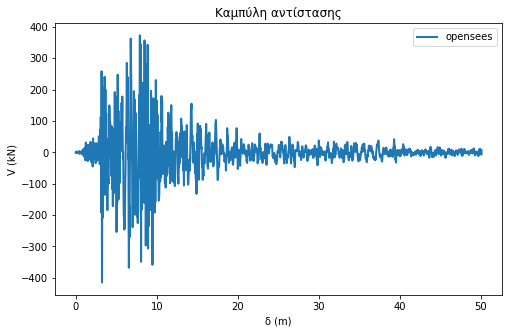

In [17]:
f, ax = plt.subplots(figsize=(8, 5))
ax.plot(time, base_shears, label="opensees", lw=2)
# ax.plot(etabs_d, etabs_V, label="etabs", lw=2)
# ax.axis([-.5, 0.5, -2000, 2300.])
ax.set_title('Καμπύλη αντίστασης')
ax.set_ylabel('V (kN)')
ax.set_xlabel('δ (m)')
ax.legend()
fig = (f, ax)
plt.show()

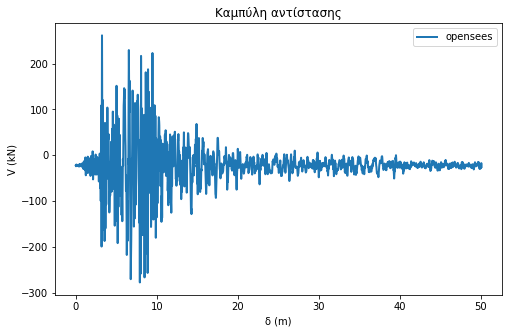

In [18]:
col1_V = np.array(out[f'element3']).transpose().astype(np.float)[2]
f, ax = plt.subplots(figsize=(8, 5))
ax.plot(time, col1_V, label="opensees", lw=2)
# ax.plot(etabs_d, etabs_V, label="etabs", lw=2)
# ax.axis([-.5, 0.5, -2000, 2300.])
ax.set_title('Καμπύλη αντίστασης')
ax.set_ylabel('V (kN)')
ax.set_xlabel('δ (m)')
ax.legend()
fig = (f, ax)
plt.show()

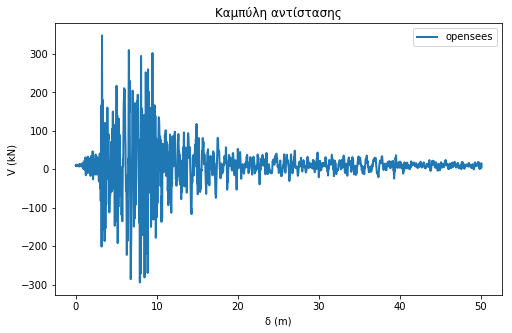

In [19]:
col2_V = np.array(out[f'element2']).transpose().astype(np.float)[2]
f, ax = plt.subplots(figsize=(8, 5))
ax.plot(time, col2_V, label="opensees", lw=2)
# ax.plot(etabs_d, etabs_V, label="etabs", lw=2)
# ax.axis([-.5, 0.5, -2000, 2300.])
ax.set_title('Καμπύλη αντίστασης')
ax.set_ylabel('V (kN)')
ax.set_xlabel('δ (m)')
ax.legend()
fig = (f, ax)
plt.show()

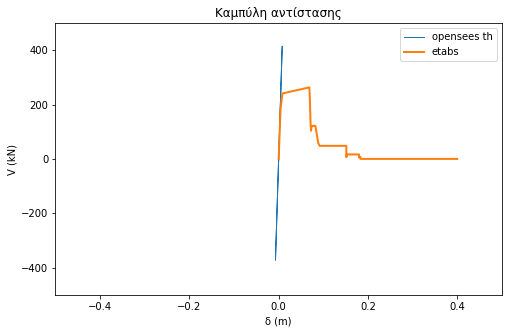

In [20]:
etabs_curve = pd.read_csv('etabs/02_userdefined.pushcurve', skiprows=7, sep='\s+')
etabs_d = etabs_curve['Displacement'].tolist()
etabs_V = etabs_curve['Base'].tolist()

f, ax = plt.subplots(figsize=(8, 5))
ax.plot(roof_displacements, -np.array(base_shears), label="opensees th", lw=1)
ax.plot(etabs_d, etabs_V, label="etabs", lw=2)
ax.axis([-.50, 0.5, -500, 500.])
ax.set_title('Καμπύλη αντίστασης')
ax.set_ylabel('V (kN)')
ax.set_xlabel('δ (m)')
ax.legend()
fig = (f, ax)
plt.show()

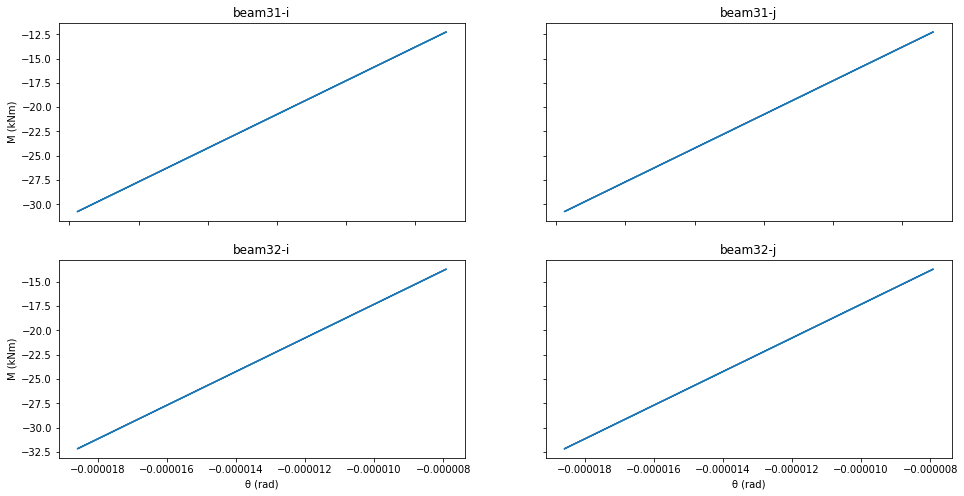

In [21]:
beam31_Mi = np.array(out[f'element31']).transpose().astype(np.float)[2]
beam31_thetai = np.array(out[f'element31deformation'])
beam31_Mj = np.array(out[f'element31']).transpose().astype(np.float)[2]
beam31_thetaj = np.array(out[f'element31deformation'])
beam32_Mi = np.array(out[f'element32']).transpose().astype(np.float)[2]
beam32_thetai = np.array(out[f'element32deformation'])
beam32_Mj = np.array(out[f'element32']).transpose().astype(np.float)[2]
beam32_thetaj = np.array(out[f'element32deformation'])

f, axs = plt.subplots(2, 2, figsize=(16, 8))
axs[0, 0].plot(beam31_thetai, beam31_Mi, '-')
axs[0, 0].set_title('beam31-i')
axs[0, 1].plot(beam31_thetaj, beam31_Mj, '-')
axs[0, 1].set_title('beam31-j')
axs[1, 0].plot(beam32_thetai, beam32_Mi, '-')
axs[1, 0].set_title('beam32-i')
axs[1, 1].plot(beam32_thetaj, beam32_Mj, '-')
axs[1, 1].set_title('beam32-j')

for ax in axs.flat:
    ax.set(xlabel='θ (rad)', ylabel='M (kNm)')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig = (f, axs)
plt.show()

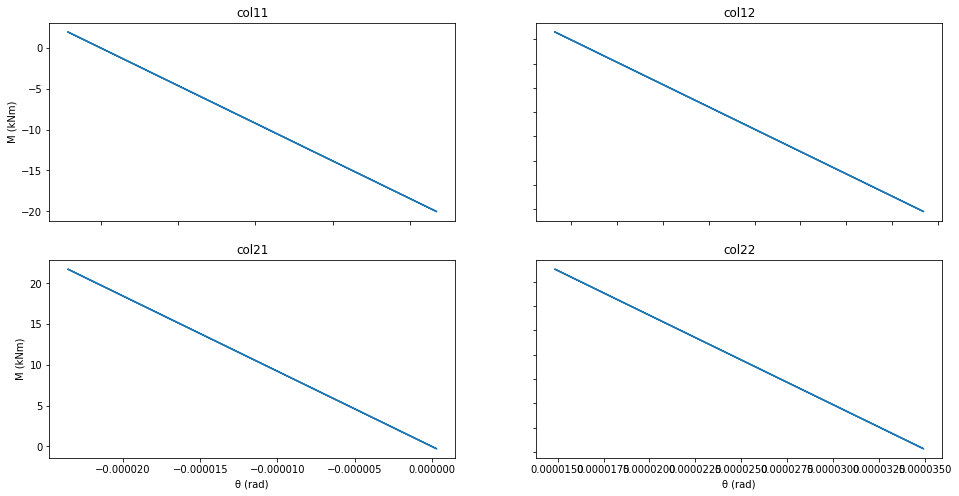

In [22]:
col11_Mi = np.array(out[f'element11']).transpose().astype(np.float)[2]
col11_thetai = np.array(out[f'element11deformation'])
col12_Mi = np.array(out[f'element12']).transpose().astype(np.float)[2]
col12_thetai = np.array(out[f'element12deformation'])
col21_Mi = np.array(out[f'element21']).transpose().astype(np.float)[2]
col21_thetai = np.array(out[f'element21deformation'])
col22_Mi = np.array(out[f'element22']).transpose().astype(np.float)[2]
col22_thetai = np.array(out[f'element22deformation'])

f, axs = plt.subplots(2, 2, figsize=(16, 8))
axs[0, 0].plot(col11_thetai, col11_Mi, '-')
axs[0, 0].set_title('col11')
axs[0, 1].plot(col12_thetai, col12_Mi, '-')
axs[0, 1].set_title('col12')
axs[1, 0].plot(col21_thetai, col21_Mi, '-')
axs[1, 0].set_title('col21')
axs[1, 1].plot(col22_thetai, col22_Mi, '-')
axs[1, 1].set_title('col22')

for ax in axs.flat:
    ax.set(xlabel='θ (rad)', ylabel='M (kNm)')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig = (f, axs)
plt.show()

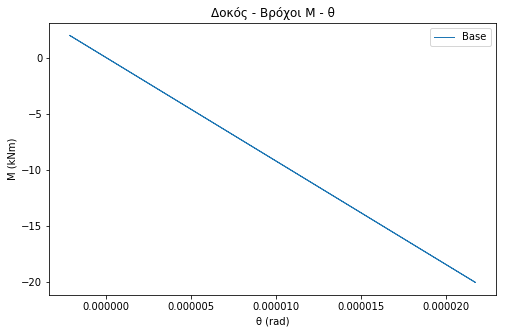

In [23]:
col1_Mi = np.array(out[f'element11']).transpose().astype(np.float)[2]
col1_thetai = np.array(out[f'element11deformation'])

f, ax = plt.subplots(figsize=(8, 5))
ax.plot(col1_thetai, col1_Mi, label="Base", lw=1)
ax.set_title('Δοκός - Βρόχοι M - θ')
ax.set_ylabel('M (kNm)')
ax.set_xlabel('θ (rad)')
ax.legend()
fig = (f, ax)
plt.show()

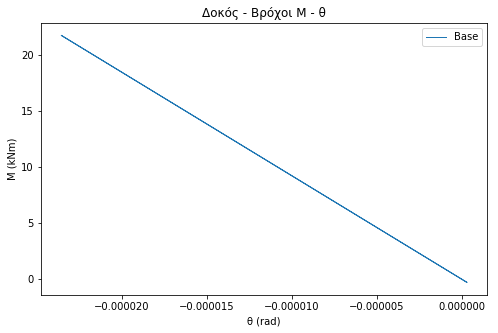

In [24]:
col2_Mi = np.array(out[f'element21']).transpose().astype(np.float)[2]
col2_thetai = np.array(out[f'element21deformation'])

f, ax = plt.subplots(figsize=(8, 5))
ax.plot(col2_thetai, col2_Mi, label="Base", lw=1)
ax.set_title('Δοκός - Βρόχοι M - θ')
ax.set_ylabel('M (kNm)')
ax.set_xlabel('θ (rad)')
ax.legend()
fig = (f, ax)
plt.show()

In [25]:
col2_Mi = np.array(out[f'zeroelement21']).transpose().astype(np.float)[5]
col2_thetai = np.array(out[f'zeroelement21deformation'])

f, ax = plt.subplots(figsize=(8, 5))
ax.plot(col2_thetai, col2_Mi, label="Base", lw=1)
ax.set_title('Δοκός - Βρόχοι M - θ')
ax.set_ylabel('M (kNm)')
ax.set_xlabel('θ (rad)')
ax.legend()
fig = (f, ax)
plt.show()

KeyError: 'zeroelement21'

In [ ]:
base_shears

In [ ]:
# out['element1']
f = gzip.open('opensees/opensees_11timehistory_out.gzpickle', 'wb', compresslevel=9)
pickle.dump(out, f)
f.close()

In [ ]:
# opensees.wipe('all')